In [1]:
"""NLTKのGutenbergコーパスを用いた著者判定の分析を行うモジュール"""
import re
from typing import Final

import nltk
import numpy as np
import shap
from pandas import DataFrame
from nltk.corpus import gutenberg

from authorship_tool.util import (
    LGBMResultModel,
    LGBMSourceModel,
    ArrayDimensionReshaper,
    FeatureDatasetGenerator,
    PosFeature,
    TypeGuardUtil,
    LGBMTrainerUtil,
    PathUtil,
)

# 必要に応じてダウンロード
# nltk.download("gutenberg")
# nltk.download("punkt")
# nltk.download("averaged_perceptron_tagger")
# nltk.download("stopwords")
print()

In [2]:
DESIRED_SCORE: Final[float] = 0.88
AUTHOR_A: Final[str] = "chesterton"
AUTHOR_B: Final[str] = "austen"

for idx, file_id in enumerate(gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")

print()

#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt



In [3]:
authors = set()

for file_id in gutenberg.fileids():
    match = re.search(r"^(.+?)-", file_id)
    if match:
        authors.add(match.group(1))

book_data_dict = {}

for index, author in enumerate(authors):
    books = [
        gutenberg.paras(file_id) for file_id in gutenberg.fileids() if author in file_id
    ]

    para_num = len([para for book in books for para in book])
    book_data_dict[author] = para_num

paragraph_num_by_author_num: dict[str, int] = dict(
    sorted(book_data_dict.items(), key=lambda pd: pd[1], reverse=True)
)

for idx, item in enumerate(paragraph_num_by_author_num.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

print()

1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs



In [4]:
books_a: list[list[list[list[str]]]] = [
    gutenberg.paras(file_id) for file_id in gutenberg.fileids() if AUTHOR_A in file_id
]

paras_a: list[list[list[str]]] = [para for book in books_a for para in book]

for para in paras_a[:10]:
    print(ArrayDimensionReshaper.para2str(para))
print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n\n")

[ The Ball and The Cross by G . K . Chesterton 1909 ]
I . A DISCUSSION SOMEWHAT IN THE AIR
The flying ship of Professor Lucifer sang through the skies like a silver arrow ; the bleak white steel of it , gleaming in the bleak blue emptiness of the evening . That it was far above the earth was no expression for it ; to the two men in it , it seemed to be far above the stars . The professor had himself invented the flying machine , and had also invented nearly everything in it . Every sort of tool or apparatus had , in consequence , to the full , that fantastic and distorted look which belongs to the miracles of science . For the world of science and evolution is far more nameless and elusive and like a dream than the world of poetry and religion ; since in the latter images and ideas remain themselves eternally , while it is the whole idea of evolution that identities melt into each other as they do in a nightmare .
All the tools of Professor Lucifer were the ancient human tools gone mad

In [5]:
books_b: list[list[list[list[str]]]] = [
    gutenberg.paras(file_id) for file_id in gutenberg.fileids() if AUTHOR_B in file_id
]

paras_b: list[list[list[str]]] = [para for book in books_b for para in book]

for para in paras_b[:10]:
    print(ArrayDimensionReshaper.para2str(para))
print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n\n")

[ Emma by Jane Austen 1816 ]
VOLUME I
CHAPTER I
Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .
She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister ' s marriage , been mistress of his house from a very early period . Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses ; and her place had been supplied by an excellent woman as governess , who had fallen little short of a mother in affection .
Sixteen years had Miss Taylor been in Mr . Woodhouse ' s family , less as a governess than a friend , very fond of both daughters , but particularly of Emma . Between _them_ it was more the intimacy of sisters . Even before Miss Taylor had ceased to hold the nominal office of gover

In [6]:
all_paras: list[list[list[str]]] = (
    paras_a + paras_b
    if TypeGuardUtil.are_paras(paras_a) and TypeGuardUtil.are_paras(paras_b)
    else []
)

if not all_paras:
    raise TypeError("paras_a or paras_b is not list[list[list[str]]] type.")

pos_set: set[str] = set(
    tag for tag in PosFeature(all_paras).classify_subcategories().pos_set
)

all_pos: list[str] = sorted(pos_set)
print(all_pos)

['$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_pp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [7]:
dataset_generator = FeatureDatasetGenerator(all_pos)
data = []
correctness = []

for para_a in paras_a:
    x, y = dataset_generator.reshape_and_generate(para_a, all_pos, True)
    data.append(x)
    correctness.append(y)

for para_b in paras_b:
    x, y = dataset_generator.reshape_and_generate(para_b, all_pos, False)
    data.append(x)
    correctness.append(y)


Then a shriek indescribable broke out of him of a sudden, and he flung up his arms like a lost spirit. The monk 
took the helm in a tired way; he did not seem much astonished for he came from an ignorant part of the world in 
which it is not uncommon for lost spirits to shriek when they see the curious shape which the Professor had just 
seen on the top of the mysterious ball, but he took the helm only just in time, and by driving it hard to the left 
he prevented the flying ship from smashing into St. Paul ' s Cathedral.

" Why this ," cried Lucifer, smiting the ball again, " here is the only symbol, my boy. So fat. So satisfied. Not 
like that scraggy individual, stretching his arms in stark weariness ." And he pointed up to the cross, his face 
dark with a grin. " I was telling you just now, Michael, that I can prove the best part of the rationalist case and
the Christian humbug from any symbol you liked to give me, from any instance I came across. Here is an instance 
with a vengeance. What could possibly express your philosophy and my philosophy better than the shape of that cross
and the shape of this ball? This globe is reasonable; that cross is unreasonable. It is a four- legged animal, with
one leg longer than the others. The globe is inevitable. The cross is arbitrary. Above all the globe is at unity 
with itself; the cross is primarily and above all things at enmity with itself. The cross is the conflict of two 
hostile lines, of irreconcilable direction. That silent thing up there is essentially a collision, a crash, a 
struggle in stone. Pah! that sacred symbol of yours has actually given its name to a description of desperation and
muddle. When we speak of men at once ignorant of each other and frustrated by each other, we say they are at cross-
purposes. Away with the thing! The very shape of it is a contradiction in terms ."

Some will think it improbable that a human soul swinging desperately in mid- air should think about philosophical 
inconsistencies. But such extreme states are dangerous things to dogmatize about. Frequently they produce a certain
useless and joyless activity of the mere intellect, thought not only divorced from hope but even from desire. And 
if it is impossible to dogmatize about such states, it is still more impossible to describe them. To this spasm of 
sanity and clarity in Michael ' s mind succeeded a spasm of the elemental terror; the terror of the animal in us 
which regards the whole universe as its enemy; which, when it is victorious, has no pity, and so, when it is 
defeated has no imaginable hope. Of that ten minutes of terror it is not possible to speak in human words. But then
again in that damnable darkness there began to grow a strange dawn as of grey and pale silver. And of this ultimate
resignation or certainty it is even less possible to write; it is something stranger than hell itself; it is 
perhaps the last of the secrets of God. At the highest crisis of some incurable anguish there will suddenly fall 
upon the man the stillness of an insane contentment. It is not hope, for hope is broken and romantic and concerned 
with the future; this is complete and of the present. It is not faith, for faith by its very nature is fierce, and 
as it were at once doubtful and defiant; but this is simply a satisfaction. It is not knowledge, for the intellect 
seems to have no particular part in it. Nor is it ( as the modern idiots would certainly say it is) a mere numbness
or negative paralysis of the powers of grief. It is not negative in the least; it is as positive as good news. In 
some sense, indeed, it is good news. It seems almost as if there were some equality among things, some balance in 
all possible contingencies which we are not permitted to know lest we should learn indifference to good and evil, 
but which is sometimes shown to us for an instant as a last aid in our last agony.

Michael certainly could not have given any sort of rational account of this vast unmeaning satisfaction which 
soaked through him and filled him to the brim. He felt with a sort of half- witted lucidity that the cross was 
there, and the ball was there, and the dome was there, that he was going to climb down from them, and that he did 
not mind in the least whether he was killed or not. This mysterious mood lasted long enough to start him on his 
dreadful descent and to force him to continue it. But six times before he reached the highest of the outer 
galleries terror had returned on him like a flying storm of darkness and thunder. By the time he had reached that 
place of safety he almost felt ( as in some impossible fit of drunkenness) that he had two heads; one was calm, 
careless, and efficient; the other saw the danger like a deadly map, was wise, careful, and useless. He had fancied
that he would have to let himself vertically down the face of the whole building. When he dropped into the upper 
gallery he still felt as far from the terrestrial globe as if he had only dropped from the sun to the moon. He 
paused a little, panting in the gallery under the ball, and idly kicked his heels, moving a few yards along it. And
as he did so a thunderbolt struck his soul. A man, a heavy, ordinary man, with a composed indifferent face, and a 
prosaic sort of uniform, with a row of buttons, blocked his way. Michael had no mind to wonder whether this solid 
astonished man, with the brown moustache and the nickel buttons, had also come on a flying ship. He merely let his 
mind float in an endless felicity about the man. He thought how nice it would be if he had to live up in that 
gallery with that one man for ever. He thought how he would luxuriate in the nameless shades of this man ' s soul 
and then hear with an endless excitement about the nameless shades of the souls of all his aunts and uncles. A 
moment before he had been dying alone. Now he was living in the same world with a man; an inexhaustible ecstasy. In
the gallery below the ball Father Michael had found that man who is the noblest and most divine and most lovable of
all men, better than all the saints, greater than all the heroes-- man Friday.

In the confused colour and music of his new paradise, Michael heard only in a faint and distant fashion some 
remarks that this beautiful solid man seemed to be making to him; remarks about something or other being after 
hours and against orders. He also seemed to be asking how Michael " got up " there. This beautiful man evidently 
felt as Michael did that the earth was a star and was set in heaven.

He was a young man, born in the Bay of Arisaig, opposite Rum and the Isle of Skye. His high, hawklike features and 
snaky black hair bore the mark of that unknown historic thing which is crudely called Celtic, but which is probably
far older than the Celts, whoever they were. He was in name and stock a Highlander of the Macdonalds; but his 
family took, as was common in such cases, the name of a subordinate sept as a surname, and for all the purposes 
which could be answered in London, he called himself Evan MacIan. He had been brought up in some loneliness and 
seclusion as a strict Roman Catholic, in the midst of that little wedge of Roman Catholics which is driven into the
Western Highlands. And he had found his way as far as Fleet Street, seeking some half- promised employment, without
having properly realized that there were in the world any people who were not Roman Catholics. He had uncovered 
himself for a few moments before the statue of Queen Anne, in front of St. Paul ' s Cathedral, under the firm 
impression that it was a figure of the Virgin Mary. He was somewhat surprised at the lack of deference shown to the
figure by the people bustling by. He did not understand that their one essential historical principle, the one law 
truly graven on their hearts, was the great and comforting statement that Queen Anne is dead. This faith was as 
fundamental as his faith, that Our Lady was alive. Any persons he had talked to since he had touched the fringe of 
our fashion or civilization had been by a coincidence, sympathetic or hypocritical. Or if they had spoken some 
established blasphemies, he had been unable to understand them merely owing to the preoccupied satisfaction of his 
mind.

With a smart journalistic instinct characteristic of all his school, the editor of _The Atheist_ had put first in 
his paper and most prominently in his window an article called " The Mesopotamian Mythology and its Effects on 
Syriac Folk Lore ." Mr. Evan MacIan began to read this quite idly, as he would have read a public statement 
beginning with a young girl dying in Brighton and ending with Bile Beans. He received the very considerable amount 
of information accumulated by the author with that tired clearness of the mind which children have on heavy summer 
afternoons-- that tired clearness which leads them to go on asking questions long after they have lost interest in 
the subject and are as bored as their nurse. The streets were full of people and empty of adventures. He might as 
well know about the gods of Mesopotamia as not; so he flattened his long, lean face against the dim bleak pane of 
the window and read all there was to read about Mesopotamian gods. He read how the Mesopotamians had a god named 
Sho ( sometimes pronounced Ji ), and that he was described as being very powerful, a striking similarity to some 
expressions about Jahveh, who is also described as having power. Evan had never heard of Jahveh in his life, and 
imagining him to be some other Mesopotamian idol, read on with a dull curiosity. He learnt that the name Sho, under
its third form of Psa, occurs in an early legend which describes how the deity, after the manner of Jupiter on so 
many occasions, seduced a Virgin and begat a hero. This hero, whose name is not essential to our existence, was, it
was said, the chief hero and Saviour of the Mesopotamian ethical scheme. Then followed a paragraph giving other 
examples of such heroes and Saviours being born of some profligate intercourse between God and mortal. Then 
followed a paragraph-- but Evan did not understand it. He read it again and then again. Then he did understand it. 
The glass fell in ringing fragments on to the pavement, and Evan sprang over the barrier into the shop, brandishing
his stick.

" But I am not in the least sorry ," said Evan, " I am very pleased ."

" Might I suggest ," he said, " That I, your worship, can settle to some extent this absurd matter myself. This 
rather wild gentleman promises that he will not attack me with any ordinary assault-- and if he does, you may be 
sure the police shall hear of it. But he says he will not. He says he will challenge me to a duel; and I cannot say
anything stronger about his mental state than to say that I think that it is highly probable that he will. ( 
Laughter .) But it takes two to make a duel, your worship ( renewed laughter ). I do not in the least mind being 
described on every wall in the world as the coward who would not fight a man in Fleet Street, about whether the 
Virgin Mary had a parallel in Mesopotamian mythology. No, your worship. You need not trouble to bind him over to 
keep the peace. I bind myself over to keep the peace, and you may rest quite satisfied that there will be no duel 
with me in it ."

The two Scotchmen were interested in seventeenth- century swords. They were fastidious about them. They had a whole
armoury of these weapons brought out and rolled clattering about the counter, until they found two of precisely the
same length. Presumably they desired the exact symmetry for some decorative trophy. Even then they felt the points,
poised the swords for balance and bent them in a circle to see that they sprang straight again; which, for 
decorative purposes, seems carrying realism rather far.

It is the one great weakness of journalism as a picture of our modern existence, that it must be a picture made up 
entirely of exceptions. We announce on flaring posters that a man has fallen off a scaffolding. We do not announce 
on flaring posters that a man has not fallen off a scaffolding. Yet this latter fact is fundamentally more 
exciting, as indicating that that moving tower of terror and mystery, a man, is still abroad upon the earth. That 
the man has not fallen off a scaffolding is really more sensational; and it is also some thousand times more 
common. But journalism cannot reasonably be expected thus to insist upon the permanent miracles. Busy editors 
cannot be expected to put on their posters, " Mr. Wilkinson Still Safe ," or " Mr. Jones, of Worthing, Not Dead Yet
." They cannot announce the happiness of mankind at all. They cannot describe all the forks that are not stolen, or
all the marriages that are not judiciously dissolved. Hence the complete picture they give of life is of necessity 
fallacious; they can only represent what is unusual. However democratic they may be, they are only concerned with 
the minority.

" It ' s a very big place. When I first came into it I was frightened of it. Frightened exactly as one would be 
frightened at the sight of a man forty feet high. I am used to big things where I come from, big mountains that 
seem to fill God ' s infinity, and the big sea that goes to the end of the world. But then these things are all 
shapeless and confused things, not made in any familiar form. But to see the plain, square, human things as large 
as that, houses so large and streets so large, and the town itself so large, was like having screwed some devil ' s
magnifying glass into one ' s eye. It was like seeing a porridge bowl as big as a house, or a mouse- trap made to 
catch elephants ."

" I am not at all surprised ," he said, " at the world being against us. It makes me feel I was right to ----"

MacIan made a violent gesture; and Turnbull broke into open laughter. The peacemaker did not seem to be in the 
least annoyed, but continued in unabated enjoyment.

" Oh, yes ," said Turnbull in a tired way, " I suppose you mean God ."

" If you pressed that point I might reply that it was very probable ," answered MacIan calmly. " I often fancy that
your historical generalizations rest frequently on random instances; I should not be surprised if your vague 
notions of the Church as the persecutor of science was a generalization from Galileo. I should not be at all 
surprised if, when you counted the scientific investigations and discoveries since the fall of Rome, you found that
a great mass of them had been made by monks. But the matter is irrelevant to my meaning. I say that if you want an 
example of anything which has progressed in the moral world by the same method as science in the material world, by
continually adding to without unsettling what was there before, then I say that there _is_ only one example of it. 
And that is Us ."

He knew that the men were rich; he knew that they were drunk; and he knew, what was worst of all, that they were 
fundamentally frightened. And he knew this also, that no common ruffian ( such as attacks ladies in novels) is ever
so savage and ruthless as a coarse kind of gentleman when he is really alarmed. The reason is not recondite; it is 
simply because the police- court is not such a menacing novelty to the poor ruffian as it is to the rich. When they
came within hail and heard the voices, they confirmed all Turnbull ' s anticipations. The man in the middle of the 
road was shouting in a hoarse and groggy voice that the chauffeur had smashed their car on purpose; that they must 
get to the Cri that evening, and that he would jolly well have to take them there. The chauffeur had mildly 
objected that he was driving a lady. " Oh! we ' ll take care of the lady ," said the red- faced young man, and went
off into gurgling and almost senile laughter.

At length Turnbull ' s opponent began to back before the battery of his heavy hands, still fighting, for he was the
soberest and boldest of the four. If these are annals of military glory, it is due to him to say that he need not 
have abandoned the conflict; only that as he backed to the edge of the ditch his foot caught in a loop of grass and
he went over in a flat and comfortable position from which it took him a considerable time to rise. By the time he 
had risen, Turnbull had come to the rescue of MacIan, who was at bay but belabouring his two enemies handsomely. 
The sight of the liberated reserve was to them like that of Blucher at Waterloo; the two set off at a sullen trot 
down the road, leaving even the walking- stick lying behind them in the moonlight. MacIan plucked the struggling 
and aspiring idiot off the back of the car like a stray cat, and left him swaying unsteadily in the moon. Then he 
approached the front part of the car in a somewhat embarrassed manner and pulled off his cap.

" Very well, sergeant ," said the young lady, with a sort of tired common sense. " I am sure I don ' t want to 
protect criminals or go against the law; but I must tell you that these gentlemen have done me a considerable 
service; you won ' t mind drawing your men a little farther off while I say good night to them. Men like that 
always misunderstand ."

After another half mile that seemed a mere flash, Turnbull leant over and locked the door. Evan staggered at last 
into his seat and hid his throbbing head in his hands; and still the car flew on and its driver sat inflexible and 
silent. The moon had already gone down, and the whole darkness was faintly troubled with twilight and the first 
movement of beasts and fowls. It was that mysterious moment when light is coming as if it were something unknown 
whose nature one could not guess-- a mere alteration in everything. They looked at the sky and it seemed as dark as
ever; then they saw the black shape of a tower or tree against it and knew that it was already grey. Save that they
were driving southward and had certainly passed the longitude of London, they knew nothing of their direction; but 
Turnbull, who had spent a year on the Hampshire coast in his youth, began to recognize the unmistakable but quite 
indescribable villages of the English south. Then a white witch fire began to burn between the black stems of the 
fir- trees; and, like so many things in nature, though not in books on evolution, the daybreak, when it did come, 
came much quicker than one would think. The gloomy heavens were ripped up and rolled away like a scroll, revealing 
splendours, as the car went roaring up the curve of a great hill; and above them and black against the broadening 
light, there stood one of those crouching and fantastic trees that are first signals of the sea.

As they came over the hill and down on the other side of it, it is not too much to say that the whole universe of 
God opened over them and under them, like a thing unfolding to five times its size. Almost under their feet opened 
the enormous sea, at the bottom of a steep valley which fell down into a bay; and the sea under their feet blazed 
at them almost as lustrous and almost as empty as the sky. The sunrise opened above them like some cosmic 
explosion, shining and shattering and yet silent; as if the world were blown to pieces without a sound. Round the 
rays of the victorious sun swept a sort of rainbow of confused and conquered colours-- brown and blue and green and
flaming rose- colour; as though gold were driving before it all the colours of the world. The lines of the 
landscape down which they sped, were the simple, strict, yet swerving, lines of a rushing river; so that it was 
almost as if they were being sucked down in a huge still whirlpool. Turnbull had some such feeling, for he spoke 
for the first time for many hours.

In the little hamlet of Haroc, in the Isle of St. Loup, there lived a man who-- though living under the English 
flag-- was absolutely untypical of the French tradition. He was quite unnoticeable, but that was exactly where he 
was quite himself. He was not even extraordinarily French; but then it is against the French tradition to be 
extraordinarily French. Ordinary Englishmen would only have thought him a little old- fashioned; imperialistic 
Englishmen would really have mistaken him for the old John Bull of the caricatures. He was stout; he was quite 
undistinguished; and he had side- whiskers, worn just a little longer than John Bull ' s. He was by name Pierre 
Durand; he was by trade a wine merchant; he was by politics a conservative republican; he had been brought up a 
Catholic, had always thought and acted as an agnostic, and was very mildly returning to the Church in his later 
years. He had a genius ( if one can even use so wild a word in connexion with so tame a person) a genius for saying
the conventional thing on every conceivable subject; or rather what we in England would call the conventional 
thing. For it was not convention with him, but solid and manly conviction. Convention implies cant or affectation, 
and he had not the faintest smell of either. He was simply an ordinary citizen with ordinary views; and if you had 
told him so he would have taken it as an ordinary compliment. If you had asked him about women, he would have said 
that one must preserve their domesticity and decorum; he would have used the stalest words, but he would have in 
reserve the strongest arguments. If you had asked him about government, he would have said that all citizens were 
free and equal, but he would have meant what he said. If you had asked him about education, he would have said that
the young must be trained up in habits of industry and of respect for their parents. Still he would have set them 
the example of industry, and he would have been one of the parents whom they could respect. A state of mind so 
hopelessly central is depressing to the English instinct. But then in England a man announcing these platitudes is 
generally a fool and a frightened fool, announcing them out of mere social servility. But Durand was anything but a
fool; he had read all the eighteenth century, and could have defended his platitudes round every angle of 
eighteenth- century argument. And certainly he was anything but a coward: swollen and sedentary as he was, he could
have hit any man back who touched him with the instant violence of an automatic machine; and dying in a uniform 
would have seemed to him only the sort of thing that sometimes happens. I am afraid it is impossible to explain 
this monster amid the exaggerative sects and the eccentric clubs of my country. He was merely a man.

" There will be another mass in a matter of eight hours ," said Madeleine, with a sort of business eagerness and 
energy, " and you can do it then before the fighting. You must forgive me, but I was so frightened that you would 
not do it at all ."

As the market- place opened before him he saw Count Gregory, that distinguished foreigner, standing and smoking in 
elegant meditation at the corner of the local café. He immediately made his way rapidly towards him, considering 
that a consultation was urgent. But he had hardly crossed half of that stony quadrangle when a window burst open 
above him and a head was thrust out, shouting. The man was in his woollen undershirt, but Turnbull knew the 
energetic, apologetic head of the sergeant of police. He pointed furiously at Turnbull and shouted his name. A 
policeman ran excitedly from under an archway and tried to collar him. Two men selling vegetables dropped their 
baskets and joined in the chase. Turnbull dodged the constable, upset one of the men into his own basket, and 
bounding towards the distinguished foreign Count, called to him clamorously: " Come on, MacIan, the hunt is up 
again ."

The two had a long race for the harbour; but the English police were heavy and the French inhabitants were 
indifferent. In any case, they got used to the notion of the road being clear; and just as they had come to the 
cliffs MacIan banged into another gentleman with unmistakable surprise. How he knew he was another gentleman merely
by banging into him, must remain a mystery. MacIan was a very poor and very sober Scotch gentleman. The other was a
very drunk and very wealthy English gentleman. But there was something in the staggered and openly embarrassed 
apologies that made them understand each other as readily and as quickly and as much as two men talking French in 
the middle of China. The nearest expression of the type is that it either hits or apologizes; and in this case both
apologized.

In this primitive and Homeric truce the week passed by; it consisted almost entirely of eating, drinking, smoking, 
talking, and occasionally singing. They wrote their records and cast loose their bottle. They never ascended to the
ominous plateau; they had never stood there save for that single embarrassed minute when they had had no time to 
take stock of the seascape or the shape of the land. They did not even explore the island; for MacIan was partly 
concerned in prayer and Turnbull entirely concerned with tobacco; and both these forms of inspiration can be 
enjoyed by the secluded and even the sedentary. It was on a golden afternoon, the sun sinking over the sea, rayed 
like the very head of Apollo, when Turnbull tossed off the last half- pint from the emptied Wilkinsonian bottle, 
hurled the bottle into the sea with objectless energy, and went up to where his sword stood waiting for him on the 
hill. MacIan was already standing heavily by his with bent head and eyes reading the ground. He had not even 
troubled to throw a glance round the island or the horizon. But Turnbull being of a more active and birdlike type 
of mind did throw a glance round the scene. The consequence of which was that he nearly fell off the rock.

" MacIan ," said Turnbull, in his temperate way, " whatever our eternal interrupted tete- a- tetes have taught us 
or not taught us, at least we need not fear the charge of fear. If it is essential to your emotions, I will 
cheerfully finish the fight here and now; but I must confess that if you kill me here I shall die with my curiosity
highly excited and unsatisfied upon a minor point of geography ."

Down the centre of the central garden path, preceded by a blue cloud from a cigarette, was walking a gentleman who 
evidently understood all the relish of a garden in the very early morning. He was a slim yet satisfied figure, clad
in a suit of pale- grey tweed, so subdued that the pattern was imperceptible-- a costume that was casual but not by
any means careless. His face, which was reflective and somewhat over- refined, was the face of a quite elderly man,
though his stringy hair and moustache were still quite yellow. A double eye- glass, with a broad, black ribbon, 
drooped from his aquiline nose, and he smiled, as he communed with himself, with a self- content which was rare and
almost irritating. The straw panama on his head was many shades shabbier than his clothes, as if he had caught it 
up by accident.

" I understood that this garden ----" began the bewildered MacIan.

" Doesn ' t it seem as if everything were being upset ?" said he; " and if once everything is upset, He will be 
upset on top of it ."

" Going on splendidly ," replied his companion in the heartiest voice. " You see, these people were much too tired 
and weak even to join the social war. They were a definite hindrance to it ."

Three weeks afterwards MacIan had managed to open up communications which made his meaning plain. By that time the 
two captives had fully discovered and demonstrated that weakness in the very nature of modern machinery to which we
have already referred. The very fact that they were isolated from all companions meant that they were free from all
spies, and as there were no gaolers to be bribed, so there were none to be baffled. Machinery brought them their 
cocoa and cleaned their cells; that machinery was as helpless as it was pitiless. A little patient violence, 
conducted day after day amid constant mutual suggestion, opened an irregular hole in the wall, large enough to let 
in a small man, in the exact place where there had been before the tiny ventilation holes. Turnbull tumbled somehow
into MacIan ' s apartment, and his first glance found out that the iron spike was indeed plucked from its socket, 
and left, moreover, another ragged hole into some hollow place behind. But for this MacIan ' s cell was the 
duplicate of Turnbull ' s-- a long oblong ending in a wedge and lined with cold and lustrous tiles. The small hole 
from which the peg had been displaced was in that short oblique wall at the end nearest to Turnbull ' s. That 
individual looked at it with a puzzled face.

" But where can the door of it be ?" said his companion, even more puzzled; " the doors of our cells are at the 
other end ."

" Good place. Yes ," said the old man, nodding a great many times and beaming like a flattered landlord. " Good 
shape. Long and narrow, with a point. Like this ," and he made lovingly with his hands a map of the room in the 
air.

" I know, I know ," said the psychologist, mournfully; " it is a most melancholy case, and also fortunately a very 
rare one. It is so rare, in fact, that in one classification of these maladies it is entered under a heading by 
itself-- Perdinavititis, mental inflammation creating the impression that one has lost a ship. Really ," he added, 
with a kind of half- embarrassed guilt, " it ' s rather a feather in my cap. I discovered the only existing case of
perdinavititis ."

" Ah !" said MacIan, with a long and satisfied sigh, " then I was right ."

The small shrill sounds which came through the crash of the conflagration were indeed of an odd sort, and MacIan 
turned a face of puzzled inquiry to his companion.

If you are interested in contributing scanning equipment or software or other items, please contact Michael Hart 
at: hart @ pobox. com

There was a rather depressed silence; the room was darkening, the sea- blighted boughs of the garden trees looked 
leaner and blacker than ever, yet they seemed to have come nearer to the window. One could almost fancy they were 
sea- monsters like krakens or cuttlefish, writhing polypi who had crawled up from the sea to see the end of this 
tragedy, even as he, the villain and victim of it, the terrible man in the tall hat, had once crawled up from the 
sea. For the whole air was dense with the morbidity of blackmail, which is the most morbid of human things, because
it is a crime concealing a crime; a black plaster on a blacker wound.

Looking around him at the confused and startled group in the hollow, Muscari then perceived that another tanned and
tattered man, with a short gun under his arm, was looking at them from the ledge just below, leaning his elbows on 
the edge of the turf. Then he looked up at the road from which they had fallen and saw, looking down on them, the 
muzzles of four other carbines and four other brown faces with bright but quite motionless eyes.

" I mean I am puzzled ," replied the priest. " I am puzzled about Ezza or Montano, or whatever his name is. He 
seems to me much more inexplicable as a brigand even than he was as a courier ."

" Why ?" asked the astonished man of letters.

" Suppose a person in a position of trust ," went on the priest, " began to give the enemy information because it 
was false information. Suppose he even thought he was saving his country by misleading the foreigner. Suppose this 
brought him into spy circles, and little loans were made to him, and little ties tied on to him. Suppose he kept up
his contradictory position in a confused way by never telling the foreign spies the truth, but letting it more and 
more be guessed. The better part of him ( what was left of it) would still say: ` I have not helped the enemy; I 
said it was the left drawer .' The meaner part of him would already be saying: ` But they may have the sense to see
that means the right .' I think it is psychologically possible-- in an enlightened age, you know ."

The first object of her diplomacy, the exit of the enraged Bruno, was at once achieved. He had already handed his 
spear in a lordly style, like a sceptre, to the piteous Parkinson, and was about to assume one of the cushioned 
seats like a throne. But at this open appeal to his rival there glowed in his opal eyeballs all the sensitive 
insolence of the slave; he knotted his enormous brown fists for an instant, and then, dashing open the door, 
disappeared into his own apartments beyond. But meanwhile Miss Rome ' s experiment in mobilizing the British Army 
had not succeeded so simply as seemed probable. Cutler had indeed risen stiffly and suddenly, and walked towards 
the door, hatless, as if at a word of command. But perhaps there was something ostentatiously elegant about the 
languid figure of Seymour leaning against one of the looking- glasses that brought him up short at the entrance, 
turning his head this way and that like a bewildered bulldog.

Seymour looked troubled for the first time. " It is hardly a point of fact ," he said, " but if his lordship would 
like me to answer for my impression, of course I shall do so. There was something about the thing that was not 
exactly a woman and yet was not quite a man; somehow the curves were different. And it had something that looked 
like long hair ."

" I got hold of him myself ," drawled the American, rising and lazily stretching his lanky legs before the fire. " 
I got hold of him with the crooked end of a walking- stick. Don ' t look so surprised. I really did. You know I 
sometimes take a turn in the country lanes outside this dismal place; well, I was walking early this evening up a 
steep lane with dark hedges and grey- looking ploughed fields on both sides; and a young moon was up and silvering 
the road. By the light of it I saw a man running across the field towards the road; running with his body bent and 
at a good mile- race trot. He appeared to be much exhausted; but when he came to the thick black hedge he went 
through it as if it were made of spiders ' webs;-- or rather ( for I heard the strong branches breaking and 
snapping like bayonets) as if he himself were made of stone. In the instant in which he appeared up against the 
moon, crossing the road, I slung my hooked cane at his legs, tripping him and bringing him down. Then I blew my 
whistle long and loud, and our fellows came running up to secure him ."

" Well, this one wasn ' t ," said Usher, throwing the papers about. " Oh, you make me tired !"

The amazed American had already parted his lips in protest when the door of his private and official room was 
hammered and rattled in an unceremonious way to which he was totally unaccustomed.

All these trivialities Brown heard and saw; but heard them as a tired man hears a tune in the railway wheels, or 
saw them as a sick man sees the pattern of his wall- paper. No one can calculate the turns of mood in 
convalescence: but Father Brown ' s depression must have had a great deal to do with his mere unfamiliarity with 
the sea. For as the river mouth narrowed like the neck of a bottle, and the water grew calmer and the air warmer 
and more earthly, he seemed to wake up and take notice like a baby. They had reached that phase just after sunset 
when air and water both look bright, but earth and all its growing things look almost black by comparison. About 
this particular evening, however, there was something exceptional. It was one of those rare atmospheres in which a 
smoked- glass slide seems to have been slid away from between us and Nature; so that even dark colours on that day 
look more gorgeous than bright colours on cloudier days. The trampled earth of the river- banks and the peaty stain
in the pools did not look drab but glowing umber, and the dark woods astir in the breeze did not look, as usual, 
dim blue with mere depth of distance, but more like wind- tumbled masses of some vivid violet blossom. This magic 
clearness and intensity in the colours was further forced on Brown ' s slowly reviving senses by something romantic
and even secret in the very form of the landscape.

The semicircle of lawn in front of the house was varied by three circular garden beds, one of red tulips, a second 
of yellow tulips, and the third of some white, waxen- looking blossoms that the visitors did not know and presumed 
to be exotic. A heavy, hairy and rather sullen- looking gardener was hanging up a heavy coil of garden hose. The 
corners of the expiring sunset which seemed to cling about the corners of the house gave glimpses here and there of
the colours of remoter flowerbeds; and in a treeless space on one side of the house opening upon the river stood a 
tall brass tripod on which was tilted a big brass telescope. Just outside the steps of the porch stood a little 
painted green garden table, as if someone had just had tea there. The entrance was flanked with two of those half- 
featured lumps of stone with holes for eyes that are said to be South Sea idols; and on the brown oak beam across 
the doorway were some confused carvings that looked almost as barbaric.

As they passed indoors, the little cleric hopped suddenly on to the table, and standing on it peered unaffectedly 
through his spectacles at the mouldings in the oak. Admiral Pendragon looked very much astonished, though not 
particularly annoyed; while Fanshaw was so amused with what looked like a performing pigmy on his little stand, 
that he could not control his laughter. But Father Brown was not likely to notice either the laughter or the 
astonishment.

There was another silence in which they heard the continuous murmur of the river; then Fanshaw said, in a doubtful 
and perhaps disappointed tone: " Then you don ' t think there is anything in the tales of the tower in flames ?"

" I hope it ' ll all end tonight ," continued the Admiral, " when my nephew comes back safe from his ship. You 
looked surprised. You won ' t understand, I suppose, unless I tell you the story. You see, my father had two sons; 
I remained a bachelor, but my elder brother married, and had a son who became a sailor like all the rest of us, and
will inherit the proper estate. Well, my father was a strange man; he somehow combined Fanshaw ' s superstition 
with a good deal of my scepticism-- they were always fighting in him; and after my first voyages, he developed a 
notion which he thought somehow would settle finally whether the curse was truth or trash. If all the Pendragons 
sailed about anyhow, he thought there would be too much chance of natural catastrophes to prove anything. But if we
went to sea one at a time in strict order of succession to the property, he thought it might show whether any 
connected fate followed the family as a family. It was a silly notion, I think, and I quarrelled with my father 
pretty heartily; for I was an ambitious man and was left to the last, coming, by succession, after my own nephew ."

Father Brown did not answer; indeed, he did not speak again, save for civilities, till they were all safe round a 
cigar- box in the cabin of the yacht. He saw that the frustrated fire was extinguished; and then refused to linger,
though he actually heard young Pendragon, escorted by an enthusiastic crowd, come tramping up the river bank; and 
might ( had he been moved by romantic curiosities) have received the combined thanks of the man from the ship and 
the girl from the canoe. But his fatigue had fallen on him once more, and he only started once, when Flambeau 
abruptly told him he had dropped cigar- ash on his trousers.

Slight as was the difference of height, it gave in those level wastes a sense of seeing yet farther and farther 
across land and sea. Inland the little wintry gardens faded into a confused grey copse; beyond that, in the 
distance, were long low barns of a lonely farmhouse, and beyond that nothing but the long East Anglian plains. 
Seawards there was no sail or sign of life save a few seagulls: and even they looked like the last snowflakes, and 
seemed to float rather than fly.

" What the devil do you mean ?" cried Flambeau, quite alarmed.

The hotel proprietor shrugged his shoulders. " They come from the other end of the town, you see-- from the 
station, three miles from here. They are only interested in the sport, and will stop in hotels for the night only. 
After all, it is hardly weather for basking on the shore ."

But he was a very different figure from the confused mass of white and black that had appeared for an instant in 
the doorway. He was buttoned and buckled up to his bursting eyeballs in the most brilliant fashion. A tall black 
hat was tilted on his broad black head-- a hat of the sort that the French wit has compared to eight mirrors. But 
somehow the black man was like the black hat. He also was black, and yet his glossy skin flung back the light at 
eight angles or more. It is needless to say that he wore white spats and a white slip inside his waistcoat. The red
flower stood up in his buttonhole aggressively, as if it had suddenly grown there. And in the way he carried his 
cane in one hand and his cigar in the other there was a certain attitude-- an attitude we must always remember when
we talk of racial prejudices: something innocent and insolent-- the cake walk.

" I had hoped he had only a little ," answered Brown in a rather troubled voice, " and I may have been wrong in 
what I did. I acted on impulse. But I fear this business has deep roots and dark ."

Father Brown was made of two men. There was a man of action, who was as modest as a primrose and as punctual as a 
clock; who went his small round of duties and never dreamed of altering it. There was also a man of reflection, who
was much simpler but much stronger, who could not easily be stopped; whose thought was always ( in the only 
intelligent sense of the words) free thought. He could not help, even unconsciously, asking himself all the 
questions that there were to be asked, and answering as many of them as he could; all that went on like his 
breathing or circulation. But he never consciously carried his actions outside the sphere of his own duty; and in 
this case the two attitudes were aptly tested. He was just about to resume his trudge in the twilight, telling 
himself it was no affair of his, but instinctively twisting and untwisting twenty theories about what the odd 
noises might mean. Then the grey sky- line brightened into silver, and in the broadening light he realized that he 
had been to the house which belonged to an Anglo- Indian Major named Putnam; and that the Major had a native cook 
from Malta who was of his communion. He also began to remember that pistol- shots are sometimes serious things; 
accompanied with consequences with which he was legitimately concerned. He turned back and went in at the garden 
gate, making for the front door.

Half- way down one side of the house stood out a projection like a very low shed; it was, as he afterwards 
discovered, a large dustbin. Round the corner of this came a figure, at first a mere shadow in the haze, apparently
bending and peering about. Then, coming nearer, it solidified into a figure that was, indeed, rather unusually 
solid. Major Putnam was a bald- headed, bull- necked man, short and very broad, with one of those rather apoplectic
faces that are produced by a prolonged attempt to combine the oriental climate with the occidental luxuries. But 
the face was a good- humoured one, and even now, though evidently puzzled and inquisitive, wore a kind of innocent 
grin. He had a large palm- leaf hat on the back of his head ( suggesting a halo that was by no means appropriate to
the face ), but otherwise he was clad only in a very vivid suit of striped scarlet and yellow pyjamas; which, 
though glowing enough to behold, must have been, on a fresh morning, pretty chilly to wear. He had evidently come 
out of his house in a hurry, and the priest was not surprised when he called out without further ceremony: " Did 
you hear that noise ?"

" Nor I ," said Father Brown faintly. " It ' s lucky you didn ' t turn your artillery on him or you might have 
given him quite a bad cold ." Then, after a bewildered pause, he said: " Was it a burglar ?"

During the last words Cray had sprung or staggered to his feet and was regarding the cleric with agitated eyes. " 
By hell, but that is a true word !" he cried. " They are all at me here that the fellow was only after the silver--
as if I shouldn ' t be only too pleased to think so! She ' s been at me ," and he tossed his tousled black head 
towards Audrey, but the other had no need of the direction, " she ' s been at me today about how cruel I was to 
shoot a poor harmless house- breaker, and how I have the devil in me against poor harmless natives. But I was a 
good- natured man once-- as good- natured as Putnam ."

" Are you interested in Catastrophism ?" asked the wondering Yankee.

" I ' m interested in catastrophes; and there are going to be some ," replied his companion gloomily. " Mine ' s a 
filthy trade, and I never pretend it isn ' t ."

" Nonsense !" said Gregory, who was very rational when anyone else attempted paradox. " Why do all the clerks and 
navvies in the railway trains look so sad and tired, so very sad and tired? I will tell you. It is because they 
know that the train is going right. It is because they know that whatever place they have taken a ticket for that 
place they will reach. It is because after they have passed Sloane Square they know that the next station must be 
Victoria, and nothing but Victoria. Oh, their wild rapture! oh, their eyes like stars and their souls again in 
Eden, if the next station were unaccountably Baker Street !"

The assembly seemed vague and sub- consciously disappointed, and Comrade Witherspoon moved restlessly on his seat 
and muttered in his thick beard. By the sheer rush of routine, however, the motion would have been put and carried.
But as the chairman was opening his mouth to put it, Syme sprang to his feet and said in a small and quiet voice--

" Does anyone second this amendment ?" he said. A tall, tired man, with melancholy eyes and an American chin beard,
was observed on the back bench to be slowly rising to his feet. Gregory had been screaming for some time past; now 
there was a change in his accent, more shocking than any scream. " I end all this !" he said, in a voice as heavy 
as stone.

" For much the same reason that you abused the police ," replied the other. " I found that there was a special 
opening in the service for those whose fears for humanity were concerned rather with the aberrations of the 
scientific intellect than with the normal and excusable, though excessive, outbreaks of the human will. I trust I 
make myself clear ."

Syme, with the perturbed promptitude he had shown since the original summons, sat down first. Gogol sat down last, 
grumbling in his brown beard about gombromise. No one except Syme seemed to have any notion of the blow that was 
about to fall. As for him, he had merely the feeling of a man mounting the scaffold with the intention, at any 
rate, of making a good speech.

The red- haired detective who had masqueraded as Gogol rose to his feet without a word, and walked out of the room 
with an air of perfect nonchalance. Yet the astonished Syme was able to realise that this ease was suddenly 
assumed; for there was a slight stumble outside the door, which showed that the departing detective had not minded 
the step.

He set off at a smart pace, twisting and whirling his stick, in the direction of Covent Garden. As he crossed the 
great market the snow increased, growing blinding and bewildering as the afternoon began to darken. The snow- 
flakes tormented him like a swarm of silver bees. Getting into his eyes and beard, they added their unremitting 
futility to his already irritated nerves; and by the time that he had come at a swinging pace to the beginning of 
Fleet Street, he lost patience, and finding a Sunday teashop, turned into it to take shelter. He ordered another 
cup of black coffee as an excuse. Scarcely had he done so, when Professor de Worms hobbled heavily into the shop, 
sat down with difficulty and ordered a glass of milk.

Syme was dumb for an instant. Then he rose to his feet erect, like an insulted man, and thrust the chair away from 
him.

" It does ," said Syme; " but I cannot help thinking that apart from all that you are really a bit worried ."

SYME sat down at a cafe table with his companions, his blue eyes sparkling like the bright sea below, and ordered a
bottle of Saumur with a pleased impatience. He was for some reason in a condition of curious hilarity. His spirits 
were already unnaturally high; they rose as the Saumur sank, and in half an hour his talk was a torrent of 
nonsense. He professed to be making out a plan of the conversation which was going to ensue between himself and the
deadly Marquis. He jotted it down wildly with a pencil. It was arranged like a printed catechism, with questions 
and answers, and was delivered with an extraordinary rapidity of utterance.

Early as was the hour, the sun soaked everything in warmth, and Syme was vaguely surprised to see so many spring 
flowers burning gold and silver in the tall grass in which the whole company stood almost knee- deep.

For one moment the heaven of Syme again grew black with supernatural terrors. Surely the man had a charmed life. 
But this new spiritual dread was a more awful thing than had been the mere spiritual topsy- turvydom symbolised by 
the paralytic who pursued him. The Professor was only a goblin; this man was a devil-- perhaps he was the Devil! 
Anyhow, this was certain, that three times had a human sword been driven into him and made no mark. When Syme had 
that thought he drew himself up, and all that was good in him sang high up in the air as a high wind sings in the 
trees. He thought of all the human things in his story-- of the Chinese lanterns in Saffron Park, of the girl ' s 
red hair in the garden, of the honest, beer- swilling sailors down by the dock, of his loyal companions standing 
by. Perhaps he had been chosen as a champion of all these fresh and kindly things to cross swords with the enemy of
all creation. " After all ," he said to himself, " I am more than a devil; I am a man. I can do the one thing which
Satan himself cannot do-- I can die ," and as the word went through his head, he heard a faint and far- off hoot, 
which would soon be the roar of the Paris train.

The Professor gave a tired gesture.

" But surely they are right away on the horizon ," said the bewildered Colonel, blinking and but half recovered 
from Bull ' s hasty though polite explanation. " Could you possibly know your President among all those people ?"

The Colonel, who greeted the innkeeper as an old friend, passed rapidly into the inn- parlour, and sat down 
ordering some ritual refreshment. The military decision of his action interested Syme, who sat next to him, and he 
took the opportunity when the old innkeeper had gone out of satisfying his curiosity.

Syme was leaning hard upon the steering wheel, and there was no sound but the rumble of the other pursuers riding 
into the town. Then there came quite suddenly a scream of scraping iron, and the car leapt forward. It plucked the 
Secretary clean out of his saddle, as a knife is whipped out of its sheath, trailed him kicking terribly for twenty
yards, and left him flung flat upon the road far in front of his frightened horse. As the car took the corner of 
the street with a splendid curve, they could just see the other anarchists filling the street and raising their 
fallen leader.

There was a puzzled pause for some little time, and then the Colonel began again abruptly--

But the impatient Colonel was already out of earshot, advancing towards the advancing enemy. The excited Dr. Renard
lifted his pistol again, but perceiving his opponent, hesitated, and the Colonel came face to face with him with 
frantic gestures of remonstrance.

" Delightful !" he said. " So pleased to see you all. What an exquisite day it is. Is the Czar dead ?"

ACROSS green fields, and breaking through blooming hedges, toiled six draggled detectives, about five miles out of 
London. The optimist of the party had at first proposed that they should follow the balloon across South England in
hansom- cabs. But he was ultimately convinced of the persistent refusal of the balloon to follow the roads, and the
still more persistent refusal of the cabmen to follow the balloon. Consequently the tireless though exasperated 
travellers broke through black thickets and ploughed through ploughed fields till each was turned into a figure too
outrageous to be mistaken for a tramp. Those green hills of Surrey saw the final collapse and tragedy of the 
admirable light grey suit in which Syme had set out from Saffron Park. His silk hat was broken over his nose by a 
swinging bough, his coat- tails were torn to the shoulder by arresting thorns, the clay of England was splashed up 
to his collar; but he still carried his yellow beard forward with a silent and furious determination, and his eyes 
were still fixed on that floating ball of gas, which in the full flush of sunset seemed coloured like a sunset 
cloud.

AS Syme strode along the corridor he saw the Secretary standing at the top of a great flight of stairs. The man had
never looked so noble. He was draped in a long robe of starless black, down the centre of which fell a band or 
broad stripe of pure white, like a single shaft of light. The whole looked like some very severe ecclesiastical 
vestment. There was no need for Syme to search his memory or the Bible in order to remember that the first day of 
creation marked the mere creation of light out of darkness. The vestment itself would alone have suggested the 
symbol; and Syme felt also how perfectly this pattern of pure white and black expressed the soul of the pale and 
austere Secretary, with his inhuman veracity and his cold frenzy, which made him so easily make war on the 
anarchists, and yet so easily pass for one of them. Syme was scarcely surprised to notice that, amid all the ease 
and hospitality of their new surroundings, this man ' s eyes were still stern. No smell of ale or orchards could 
make the Secretary cease to ask a reasonable question.

The event had every promise of happiness for her friend. Mr. Weston was a man of unexceptionable character, easy 
fortune, suitable age, and pleasant manners; and there was some satisfaction in considering with what self- 
denying, generous friendship she had always wished and promoted the match; but it was a black morning ' s work for 
her. The want of Miss Taylor would be felt every hour of every day. She recalled her past kindness-- the kindness, 
the affection of sixteen years-- how she had taught and how she had played with her from five years old-- how she 
had devoted all her powers to attach and amuse her in health-- and how nursed her through the various illnesses of 
childhood. A large debt of gratitude was owing here; but the intercourse of the last seven years, the equal footing
and perfect unreserve which had soon followed Isabella ' s marriage, on their being left to each other, was yet a 
dearer, tenderer recollection. She had been a friend and companion such as few possessed: intelligent, well- 
informed, useful, gentle, knowing all the ways of the family, interested in all its concerns, and peculiarly 
interested in herself, in every pleasure, every scheme of hers-- one to whom she could speak every thought as it 
arose, and who had such an affection for her as could never find fault.

Mrs. Bates, the widow of a former vicar of Highbury, was a very old lady, almost past every thing but tea and 
quadrille. She lived with her single daughter in a very small way, and was considered with all the regard and 
respect which a harmless old lady, under such untoward circumstances, can excite. Her daughter enjoyed a most 
uncommon degree of popularity for a woman neither young, handsome, rich, nor married. Miss Bates stood in the very 
worst predicament in the world for having much of the public favour; and she had no intellectual superiority to 
make atonement to herself, or frighten those who might hate her into outward respect. She had never boasted either 
beauty or cleverness. Her youth had passed without distinction, and her middle of life was devoted to the care of a
failing mother, and the endeavour to make a small income go as far as possible. And yet she was a happy woman, and 
a woman whom no one named without good- will. It was her own universal good- will and contented temper which worked
such wonders. She loved every body, was interested in every body ' s happiness, quicksighted to every body ' s 
merits; thought herself a most fortunate creature, and surrounded with blessings in such an excellent mother, and 
so many good neighbours and friends, and a home that wanted for nothing. The simplicity and cheerfulness of her 
nature, her contented and grateful spirit, were a recommendation to every body, and a mine of felicity to herself. 
She was a great talker upon little matters, which exactly suited Mr. Woodhouse, full of trivial communications and 
harmless gossip.

These were the ladies whom Emma found herself very frequently able to collect; and happy was she, for her father ' 
s sake, in the power; though, as far as she was herself concerned, it was no remedy for the absence of Mrs. Weston.
She was delighted to see her father look comfortable, and very much pleased with herself for contriving things so 
well; but the quiet prosings of three such women made her feel that every evening so spent was indeed one of the 
long evenings she had fearfully anticipated.

She was a very pretty girl, and her beauty happened to be of a sort which Emma particularly admired. She was short,
plump, and fair, with a fine bloom, blue eyes, light hair, regular features, and a look of great sweetness, and, 
before the end of the evening, Emma was as much pleased with her manners as her person, and quite determined to 
continue the acquaintance.

Emma allowed her father to talk-- but supplied her visitors in a much more satisfactory style, and on the present 
evening had particular pleasure in sending them away happy. The happiness of Miss Smith was quite equal to her 
intentions. Miss Woodhouse was so great a personage in Highbury, that the prospect of the introduction had given as
much panic as pleasure; but the humble, grateful little girl went off with highly gratified feelings, delighted 
with the affability with which Miss Woodhouse had treated her all the evening, and actually shaken hands with her 
at last!

Harriet certainly was not clever, but she had a sweet, docile, grateful disposition, was totally free from conceit,
and only desiring to be guided by any one she looked up to. Her early attachment to herself was very amiable; and 
her inclination for good company, and power of appreciating what was elegant and clever, shewed that there was no 
want of taste, though strength of understanding must not be expected. Altogether she was quite convinced of Harriet
Smith ' s being exactly the young friend she wanted-- exactly the something which her home required. Such a friend 
as Mrs. Weston was out of the question. Two such could never be granted. Two such she did not want. It was quite a 
different sort of thing, a sentiment distinct and independent. Mrs. Weston was the object of a regard which had its
basis in gratitude and esteem. Harriet would be loved as one to whom she could be useful. For Mrs. Weston there was
nothing to be done; for Harriet every thing.

Emma could not feel a doubt of having given Harriet ' s fancy a proper direction and raised the gratitude of her 
young vanity to a very good purpose, for she found her decidedly more sensible than before of Mr. Elton ' s being a
remarkably handsome man, with most agreeable manners; and as she had no hesitation in following up the assurance of
his admiration by agreeable hints, she was soon pretty confident of creating as much liking on Harriet ' s side, as
there could be any occasion for. She was quite convinced of Mr. Elton ' s being in the fairest way of falling in 
love, if not in love already. She had no scruple with regard to him. He talked of Harriet, and praised her so 
warmly, that she could not suppose any thing wanting which a little time would not add. His perception of the 
striking improvement of Harriet ' s manner, since her introduction at Hartfield, was not one of the least agreeable
proofs of his growing attachment.

" I have no doubt of it ." And it was spoken with a sort of sighing animation, which had a vast deal of the lover. 
She was not less pleased another day with the manner in which he seconded a sudden wish of hers, to have Harriet ' 
s picture.

The sitting was altogether very satisfactory; she was quite enough pleased with the first day ' s sketch to wish to
go on. There was no want of likeness, she had been fortunate in the attitude, and as she meant to throw in a little
improvement to the figure, to give a little more height, and considerably more elegance, she had great confidence 
of its being in every way a pretty drawing at last, and of its filling its destined place with credit to them 
both-- a standing memorial of the beauty of one, the skill of the other, and the friendship of both; with as many 
other agreeable associations as Mr. Elton ' s very promising attachment was likely to add.

The same civilities and courtesies, the same success and satisfaction, took place on the morrow, and accompanied 
the whole progress of the picture, which was rapid and happy. Every body who saw it was pleased, but Mr. Elton was 
in continual raptures, and defended it through every criticism.

The very day of Mr. Elton ' s going to London produced a fresh occasion for Emma ' s services towards her friend. 
Harriet had been at Hartfield, as usual, soon after breakfast; and, after a time, had gone home to return again to 
dinner: she returned, and sooner than had been talked of, and with an agitated, hurried look, announcing something 
extraordinary to have happened which she was longing to tell. Half a minute brought it all out. She had heard, as 
soon as she got back to Mrs. Goddard ' s, that Mr. Martin had been there an hour before, and finding she was not at
home, nor particularly expected, had left a little parcel for her from one of his sisters, and gone away; and on 
opening this parcel, she had actually found, besides the two songs which she had lent Elizabeth to copy, a letter 
to herself; and this letter was from him, from Mr. Martin, and contained a direct proposal of marriage. " Who could
have thought it? She was so surprized she did not know what to do. Yes, quite a proposal of marriage; and a very 
good letter, at least she thought so. And he wrote as if he really loved her very much-- but she did not know-- and
so, she was come as fast as she could to ask Miss Woodhouse what she should do .--" Emma was half- ashamed of her 
friend for seeming so pleased and so doubtful.

The symptoms were favourable .-- Instead of answering, Harriet turned away confused, and stood thoughtfully by the 
fire; and though the letter was still in her hand, it was now mechanically twisted about without regard. Emma 
waited the result with impatience, but not without strong hopes. At last, with some hesitation, Harriet said--

" Depend upon it, Elton will not do. Elton is a very good sort of man, and a very respectable vicar of Highbury, 
but not at all likely to make an imprudent match. He knows the value of a good income as well as any body. Elton 
may talk sentimentally, but he will act rationally. He is as well acquainted with his own claims, as you can be 
with Harriet ' s. He knows that he is a very handsome young man, and a great favourite wherever he goes; and from 
his general way of talking in unreserved moments, when there are only men present, I am convinced that he does not 
mean to throw himself away. I have heard him speak with great animation of a large family of young ladies that his 
sisters are intimate with, who have all twenty thousand pounds apiece ."

Emma remained in a state of vexation too; but there was more indistinctness in the causes of her ' s, than in his. 
She did not always feel so absolutely satisfied with herself, so entirely convinced that her opinions were right 
and her adversary ' s wrong, as Mr. Knightley. He walked off in more complete self- approbation than he left for 
her. She was not so materially cast down, however, but that a little time and the return of Harriet were very 
adequate restoratives. Harriet ' s staying away so long was beginning to make her uneasy. The possibility of the 
young man ' s coming to Mrs. Goddard ' s that morning, and meeting with Harriet and pleading his own cause, gave 
alarming ideas. The dread of such a failure after all became the prominent uneasiness; and when Harriet appeared, 
and in very good spirits, and without having any such reason to give for her long absence, she felt a satisfaction 
which settled her with her own mind, and convinced her, that let Mr. Knightley think or say what he would, she had 
done nothing which woman ' s friendship and woman ' s feelings would not justify.

He had frightened her a little about Mr. Elton; but when she considered that Mr. Knightley could not have observed 
him as she had done, neither with the interest, nor ( she must be allowed to tell herself, in spite of Mr. 
Knightley ' s pretensions) with the skill of such an observer on such a question as herself, that he had spoken it 
hastily and in anger, she was able to believe, that he had rather said what he wished resentfully to be true, than 
what he knew any thing about. He certainly might have heard Mr. Elton speak with more unreserve than she had ever 
done, and Mr. Elton might not be of an imprudent, inconsiderate disposition as to money matters; he might naturally
be rather attentive than otherwise to them; but then, Mr. Knightley did not make due allowance for the influence of
a strong passion at war with all interested motives. Mr. Knightley saw no such passion, and of course thought 
nothing of its effects; but she saw too much of it to feel a doubt of its overcoming any hesitations that a 
reasonable prudence might originally suggest; and more than a reasonable, becoming degree of prudence, she was very
sure did not belong to Mr. Elton.

Mr. Woodhouse was almost as much interested in the business as the girls, and tried very often to recollect 
something worth their putting in. " So many clever riddles as there used to be when he was young-- he wondered he 
could not remember them! but he hoped he should in time ." And it always ended in " Kitty, a fair but frozen maid 
."

The very next day however produced some proof of inspiration. He called for a few moments, just to leave a piece of
paper on the table containing, as he said, a charade, which a friend of his had addressed to a young lady, the 
object of his admiration, but which, from his manner, Emma was immediately convinced must be his own.

" Yes, my dear, if there is time .-- But --( in a very depressed tone )-- she is coming for only one week. There 
will not be time for any thing ."

" That is as formidable an image as you could present, Harriet; and if I thought I should ever be like Miss Bates! 
so silly-- so satisfied-- so smiling-- so prosing-- so undistinguishing and unfastidious-- and so apt to tell every
thing relative to every body about me, I would marry to- morrow. But between _us_, I am convinced there never can 
be any likeness, except in being unmarried ."

Anxious to separate herself from them as far as she could, she soon afterwards took possession of a narrow 
footpath, a little raised on one side of the lane, leaving them together in the main road. But she had not been 
there two minutes when she found that Harriet ' s habits of dependence and imitation were bringing her up too, and 
that, in short, they would both be soon after her. This would not do; she immediately stopped, under pretence of 
having some alteration to make in the lacing of her half- boot, and stooping down in complete occupation of the 
footpath, begged them to have the goodness to walk on, and she would follow in half a minute. They did as they were
desired; and by the time she judged it reasonable to have done with her boot, she had the comfort of farther delay 
in her power, being overtaken by a child from the cottage, setting out, according to orders, with her pitcher, to 
fetch broth from Hartfield. To walk by the side of this child, and talk to and question her, was the most natural 
thing in the world, or would have been the most natural, had she been acting just then without design; and by this 
means the others were still able to keep ahead, without any obligation of waiting for her. She gained on them, 
however, involuntarily: the child ' s pace was quick, and theirs rather slow; and she was the more concerned at it,
from their being evidently in a conversation which interested them. Mr. Elton was speaking with animation, Harriet 
listening with a very pleased attention; and Emma, having sent the child on, was beginning to think how she might 
draw back a little more, when they both looked around, and she was obliged to join them.

" That ' s true ," she cried --" very true. Little Emma, grow up a better woman than your aunt. Be infinitely 
cleverer and not half so conceited. Now, Mr. Knightley, a word or two more, and I have done. As far as good 
intentions went, we were _both_ right, and I must say that no effects on my side of the argument have yet proved 
wrong. I only want to know that Mr. Martin is not very, very bitterly disappointed ."

" My poor dear Isabella ," said he, fondly taking her hand, and interrupting, for a few moments, her busy labours 
for some one of her five children --" How long it is, how terribly long since you were here! And how tired you must
be after your journey! You must go to bed early, my dear-- and I recommend a little gruel to you before you go .-- 
You and I will have a nice basin of gruel together. My dear Emma, suppose we all have a little gruel ."

" And Mrs. Perry and the children, how are they? do the children grow? I have a great regard for Mr. Perry. I hope 
he will be calling soon. He will be so pleased to see my little ones ."

" Oh! the good Bateses-- I am quite ashamed of myself-- but you mention them in most of your letters. I hope they 
are quite well. Good old Mrs. Bates-- I will call upon her to- morrow, and take my children .-- They are always so 
pleased to see my children .-- And that excellent Miss Bates !-- such thorough worthy people !-- How are they, sir 
?"

" I am sorry to hear you say so, sir; but I assure you, excepting those little nervous head- aches and palpitations
which I am never entirely free from anywhere, I am quite well myself; and if the children were rather pale before 
they went to bed, it was only because they were a little more tired than usual, from their journey and the 
happiness of coming. I hope you will think better of their looks to- morrow; for I assure you Mr. Wingfield told 
me, that he did not believe he had ever sent us off altogether, in such good case. I trust, at least, that you do 
not think Mr. Knightley looking ill ," turning her eyes with affectionate anxiety towards her husband.

" I thank you; but I assure you you are quite mistaken. Mr. Elton and I are very good friends, and nothing more ;" 
and she walked on, amusing herself in the consideration of the blunders which often arise from a partial knowledge 
of circumstances, of the mistakes which people of high pretensions to judgment are for ever falling into; and not 
very well pleased with her brother for imagining her blind and ignorant, and in want of counsel. He said no more.

Emma did not find herself equal to give the pleased assent, which no doubt he was in the habit of receiving, to 
emulate the " Very true, my love ," which must have been usually administered by his travelling companion; but she 
had resolution enough to refrain from making any answer at all. She could not be complying, she dreaded being 
quarrelsome; her heroism reached only to silence. She allowed him to talk, and arranged the glasses, and wrapped 
herself up, without opening her lips.

Emma ' s project of forgetting Mr. Elton for a while made her rather sorry to find, when they had all taken their 
places, that he was close to her. The difficulty was great of driving his strange insensibility towards Harriet, 
from her mind, while he not only sat at her elbow, but was continually obtruding his happy countenance on her 
notice, and solicitously addressing her upon every occasion. Instead of forgetting him, his behaviour was such that
she could not avoid the internal suggestion of " Can it really be as my brother imagined? can it be possible for 
this man to be beginning to transfer his affections from Harriet to me ?-- Absurd and insufferable !"-- Yet he 
would be so anxious for her being perfectly warm, would be so interested about her father, and so delighted with 
Mrs. Weston; and at last would begin admiring her drawings with so much zeal and so little knowledge as seemed 
terribly like a would- be lover, and made it some effort with her to preserve her good manners. For her own sake 
she could not be rude; and for Harriet ' s, in the hope that all would yet turn out right, she was even positively 
civil; but it was an effort; especially as something was going on amongst the others, in the most overpowering 
period of Mr. Elton ' s nonsense, which she particularly wished to listen to. She heard enough to know that Mr. 
Weston was giving some information about his son; she heard the words " my son ," and " Frank ," and " my son ," 
repeated several times over; and, from a few other half- syllables very much suspected that he was announcing an 
early visit from his son; but before she could quiet Mr. Elton, the subject was so completely past that any 
reviving question from her would have been awkward.

To Mr. John Knightley was she indebted for her first idea on the subject, for the first start of its possibility. 
There was no denying that those brothers had penetration. She remembered what Mr. Knightley had once said to her 
about Mr. Elton, the caution he had given, the conviction he had professed that Mr. Elton would never marry 
indiscreetly; and blushed to think how much truer a knowledge of his character had been there shewn than any she 
had reached herself. It was dreadfully mortifying; but Mr. Elton was proving himself, in many respects, the very 
reverse of what she had meant and believed him; proud, assuming, conceited; very full of his own claims, and little
concerned about the feelings of others.

The first error and the worst lay at her door. It was foolish, it was wrong, to take so active a part in bringing 
any two people together. It was adventuring too far, assuming too much, making light of what ought to be serious, a
trick of what ought to be simple. She was quite concerned and ashamed, and resolved to do such things no more.

The weather was most favourable for her; though Christmas Day, she could not go to church. Mr. Woodhouse would have
been miserable had his daughter attempted it, and she was therefore safe from either exciting or receiving 
unpleasant and most unsuitable ideas. The ground covered with snow, and the atmosphere in that unsettled state 
between frost and thaw, which is of all others the most unfriendly for exercise, every morning beginning in rain or
snow, and every evening setting in to freeze, she was for many days a most honourable prisoner. No intercourse with
Harriet possible but by note; no church for her on Sunday any more than on Christmas Day; and no need to find 
excuses for Mr. Elton ' s absenting himself.

It was weather which might fairly confine every body at home; and though she hoped and believed him to be really 
taking comfort in some society or other, it was very pleasant to have her father so well satisfied with his being 
all alone in his own house, too wise to stir out; and to hear him say to Mr. Knightley, whom no weather could keep 
entirely from them ,--

Mrs. Weston was exceedingly disappointed-- much more disappointed, in fact, than her husband, though her dependence
on seeing the young man had been so much more sober: but a sanguine temper, though for ever expecting more good 
than occurs, does not always pay for its hopes by any proportionate depression. It soon flies over the present 
failure, and begins to hope again. For half an hour Mr. Weston was surprized and sorry; but then he began to 
perceive that Frank ' s coming two or three months later would be a much better plan; better time of year; better 
weather; and that he would be able, without any doubt, to stay considerably longer with them than if he had come 
sooner.

" I am concerned to hear of it. I think they judge wisely. But Mrs. Dixon must be very much disappointed. Mrs. 
Dixon, I understand, has no remarkable degree of personal beauty; is not, by any means, to be compared with Miss 
Fairfax ."

" Oh! no; I was pleased with my own perseverance in asking questions; and amused to think how little information I 
obtained ."

" I am disappointed ," was his only answer.

Mr. Knightley looked as if he were more gratified than he cared to express; and before he could make any reply, Mr.
Woodhouse, whose thoughts were on the Bates ' s, said--

" A new neighbour for us all, Miss Woodhouse !" said Miss Bates, joyfully; " my mother is so pleased !-- she says 
she cannot bear to have the poor old Vicarage without a mistress. This is great news, indeed. Jane, you have never 
seen Mr. Elton !-- no wonder that you have such a curiosity to see him ."

" When I have seen Mr. Elton ," replied Jane, " I dare say I shall be interested-- but I believe it requires _that_
with me. And as it is some months since Miss Campbell married, the impression may be a little worn off ."

Harriet said, " very true ," and she " would not think about it ;" but still she talked of it-- still she could 
talk of nothing else; and Emma, at last, in order to put the Martins out of her head, was obliged to hurry on the 
news, which she had meant to give with so much tender caution; hardly knowing herself whether to rejoice or be 
angry, ashamed or only amused, at such a state of mind in poor Harriet-- such a conclusion of Mr. Elton ' s 
importance with her!

" This is too bad ," cried Emma, as they turned away. " And now we shall just miss them; too provoking !-- I do not
know when I have been so disappointed ." And she leaned back in the corner, to indulge her murmurs, or to reason 
them away; probably a little of both-- such being the commonest process of a not ill- disposed mind. Presently the 
carriage stopt; she looked up; it was stopt by Mr. and Mrs. Weston, who were standing to speak to her. There was 
instant pleasure in the sight of them, and still greater pleasure was conveyed in sound-- for Mr. Weston 
immediately accosted her with,

There was no resisting such news, no possibility of avoiding the influence of such a happy face as Mr. Weston ' s, 
confirmed as it all was by the words and the countenance of his wife, fewer and quieter, but not less to the 
purpose. To know that _she_ thought his coming certain was enough to make Emma consider it so, and sincerely did 
she rejoice in their joy. It was a most delightful reanimation of exhausted spirits. The worn- out past was sunk in
the freshness of what was coming; and in the rapidity of half a moment ' s thought, she hoped Mr. Elton would now 
be talked of no more.

He had reached Randalls the evening before. She was pleased with the eagerness to arrive which had made him alter 
his plan, and travel earlier, later, and quicker, that he might gain half a day.

The son looked convinced.

They were permitted to go alone; and with a cordial nod from one, and a graceful bow from the other, the two 
gentlemen took leave. Emma remained very well pleased with this beginning of the acquaintance, and could now engage
to think of them all at Randalls any hour of the day, with full confidence in their comfort.

Their first pause was at the Crown Inn, an inconsiderable house, though the principal one of the sort, where a 
couple of pair of post- horses were kept, more for the convenience of the neighbourhood than from any run on the 
road; and his companions had not expected to be detained by any interest excited there; but in passing it they gave
the history of the large room visibly added; it had been built many years ago for a ball- room, and while the 
neighbourhood had been in a particularly populous, dancing state, had been occasionally used as such ;-- but such 
brilliant days had long passed away, and now the highest purpose for which it was ever wanted was to accommodate a 
whist club established among the gentlemen and half- gentlemen of the place. He was immediately interested. Its 
character as a ball- room caught him; and instead of passing on, he stopt for several minutes at the two superior 
sashed windows which were open, to look in and contemplate its capabilities, and lament that its original purpose 
should have ceased. He saw no fault in the room, he would acknowledge none which they suggested. No, it was long 
enough, broad enough, handsome enough. It would hold the very number for comfort. They ought to have balls there at
least every fortnight through the winter. Why had not Miss Woodhouse revived the former good old days of the room 
?-- She who could do any thing in Highbury! The want of proper families in the place, and the conviction that none 
beyond the place and its immediate environs could be tempted to attend, were mentioned; but he was not satisfied. 
He could not be persuaded that so many good- looking houses as he saw around him, could not furnish numbers enough 
for such a meeting; and even when particulars were given and families described, he was still unwilling to admit 
that the inconvenience of such a mixture would be any thing, or that there would be the smallest difficulty in 
every body ' s returning into their proper place the next morning. He argued like a young man very much bent on 
dancing; and Emma was rather surprized to see the constitution of the Weston prevail so decidedly against the 
habits of the Churchills. He seemed to have all the life and spirit, cheerful feelings, and social inclinations of 
his father, and nothing of the pride or reserve of Enscombe. Of pride, indeed, there was, perhaps, scarcely enough;
his indifference to a confusion of rank, bordered too much on inelegance of mind. He could be no judge, however, of
the evil he was holding cheap. It was but an effusion of lively spirits.

" Proof indeed !" said Emma, highly amused .--" Mr. Dixon is very musical, is he? We shall know more about them 
all, in half an hour, from you, than Miss Fairfax would have vouchsafed in half a year ."

" You will make my excuses, my dear, as civilly as possible. You will say that I am quite an invalid, and go no 
where, and therefore must decline their obliging invitation; beginning with my _compliments_, of course. But you 
will do every thing right. I need not tell you what is to be done. We must remember to let James know that the 
carriage will be wanted on Tuesday. I shall have no fears for you with him. We have never been there above once 
since the new approach was made; but still I have no doubt that James will take you very safely. And when you get 
there, you must tell him at what time you would have him come for you again; and you had better name an early hour.
You will not like staying late. You will get very tired when tea is over ."

" But you would not wish me to come away before I am tired, papa ?"

She followed another carriage to Mr. Cole ' s door; and was pleased to see that it was Mr. Knightley ' s; for Mr. 
Knightley keeping no horses, having little spare money and a great deal of health, activity, and independence, was 
too apt, in Emma ' s opinion, to get about as he could, and not use his carriage so often as became the owner of 
Donwell Abbey. She had an opportunity now of speaking her approbation while warm from her heart, for he stopped to 
hand her out.

Mrs. Cole had many to agree with her; every body who spoke on the subject was equally convinced that it must come 
from Colonel Campbell, and equally rejoiced that such a present had been made; and there were enough ready to speak
to allow Emma to think her own way, and still listen to Mrs. Cole.

The ladies had not been long in the drawing- room, before the other ladies, in their different divisions, arrived. 
Emma watched the entree of her own particular little friend; and if she could not exult in her dignity and grace, 
she could not only love the blooming sweetness and the artless manner, but could most heartily rejoice in that 
light, cheerful, unsentimental disposition which allowed her so many alleviations of pleasure, in the midst of the 
pangs of disappointed affection. There she sat-- and who would have guessed how many tears she had been lately 
shedding? To be in company, nicely dressed herself and seeing others nicely dressed, to sit and smile and look 
pretty, and say nothing, was enough for the happiness of the present hour. Jane Fairfax did look and move superior;
but Emma suspected she might have been glad to change feelings with Harriet, very glad to have purchased the 
mortification of having loved-- yes, of having loved even Mr. Elton in vain-- by the surrender of all the dangerous
pleasure of knowing herself beloved by the husband of her friend.

Mrs. Weston, kind- hearted and musical, was particularly interested by the circumstance, and Emma could not help 
being amused at her perseverance in dwelling on the subject; and having so much to ask and to say as to tone, 
touch, and pedal, totally unsuspicious of that wish of saying as little about it as possible, which she plainly 
read in the fair heroine ' s countenance.

" For shame, Emma! Do not mimic her. You divert me against my conscience. And, upon my word, I do not think Mr. 
Knightley would be much disturbed by Miss Bates. Little things do not irritate him. She might talk on; and if he 
wanted to say any thing himself, he would only talk louder, and drown her voice. But the question is not, whether 
it would be a bad connexion for him, but whether he wishes it; and I think he does. I have heard him speak, and so 
must you, so very highly of Jane Fairfax! The interest he takes in her-- his anxiety about her health-- his concern
that she should have no happier prospect! I have heard him express himself so warmly on those points !-- Such an 
admirer of her performance on the pianoforte, and of her voice! I have heard him say that he could listen to her 
for ever. Oh! and I had almost forgotten one idea that occurred to me-- this pianoforte that has been sent here by 
somebody-- though we have all been so well satisfied to consider it a present from the Campbells, may it not be 
from Mr. Knightley? I cannot help suspecting him. I think he is just the person to do it, even without being in 
love ."

" I thought you meant to go with me. They would be very much pleased ."

" Aye, that will be much best ," said Harriet, quite satisfied, " I should not at all like to have it sent to Mrs. 
Goddard ' s ."

" Very well, I am much obliged to you. My mother is delightfully well; and Jane caught no cold last night. How is 
Mr. Woodhouse ?-- I am so glad to hear such a good account. Mrs. Weston told me you were here .-- Oh! then, said I,
I must run across, I am sure Miss Woodhouse will allow me just to run across and entreat her to come in; my mother 
will be so very happy to see her-- and now we are such a nice party, she cannot refuse .--` Aye, pray do ,' said 
Mr. Frank Churchill, ` Miss Woodhouse ' s opinion of the instrument will be worth having .'-- But, said I, I shall 
be more sure of succeeding if one of you will go with me .--` Oh ,' said he, ` wait half a minute, till I have 
finished my job ;'-- For, would you believe it, Miss Woodhouse, there he is, in the most obliging manner in the 
world, fastening in the rivet of my mother ' s spectacles .-- The rivet came out, you know, this morning .-- So 
very obliging !-- For my mother had no use of her spectacles-- could not put them on. And, by the bye, every body 
ought to have two pair of spectacles; they should indeed. Jane said so. I meant to take them over to John Saunders 
the first thing I did, but something or other hindered me all the morning; first one thing, then another, there is 
no saying what, you know. At one time Patty came to say she thought the kitchen chimney wanted sweeping. Oh, said 
I, Patty do not come with your bad news to me. Here is the rivet of your mistress ' s spectacles out. Then the 
baked apples came home, Mrs. Wallis sent them by her boy; they are extremely civil and obliging to us, the 
Wallises, always-- I have heard some people say that Mrs. Wallis can be uncivil and give a very rude answer, but we
have never known any thing but the greatest attention from them. And it cannot be for the value of our custom now, 
for what is our consumption of bread, you know? Only three of us .-- besides dear Jane at present-- and she really 
eats nothing-- makes such a shocking breakfast, you would be quite frightened if you saw it. I dare not let my 
mother know how little she eats-- so I say one thing and then I say another, and it passes off. But about the 
middle of the day she gets hungry, and there is nothing she likes so well as these baked apples, and they are 
extremely wholesome, for I took the opportunity the other day of asking Mr. Perry; I happened to meet him in the 
street. Not that I had any doubt before-- I have so often heard Mr. Woodhouse recommend a baked apple. I believe it
is the only way that Mr. Woodhouse thinks the fruit thoroughly wholesome. We have apple- dumplings, however, very 
often. Patty makes an excellent apple- dumpling. Well, Mrs. Weston, you have prevailed, I hope, and these ladies 
will oblige us ."

" I declare I cannot recollect what I was talking of .-- Oh! my mother ' s spectacles. So very obliging of Mr. 
Frank Churchill! ` Oh !' said he, ` I do think I can fasten the rivet; I like a job of this kind excessively .'-- 
Which you know shewed him to be so very.... Indeed I must say that, much as I had heard of him before and much as I
had expected, he very far exceeds any thing.... I do congratulate you, Mrs. Weston, most warmly. He seems every 
thing the fondest parent could.... ` Oh !' said he, ` I can fasten the rivet. I like a job of that sort excessively
.' I never shall forget his manner. And when I brought out the baked apples from the closet, and hoped our friends 
would be so very obliging as to take some, ` Oh !' said he directly, ` there is nothing in the way of fruit half so
good, and these are the finest- looking home- baked apples I ever saw in my life .' That, you know, was so very....
And I am sure, by his manner, it was no compliment. Indeed they are very delightful apples, and Mrs. Wallis does 
them full justice-- only we do not have them baked more than twice, and Mr. Woodhouse made us promise to have them 
done three times-- but Miss Woodhouse will be so good as not to mention it. The apples themselves are the very 
finest sort for baking, beyond a doubt; all from Donwell-- some of Mr. Knightley ' s most liberal supply. He sends 
us a sack every year; and certainly there never was such a keeping apple anywhere as one of his trees-- I believe 
there is two of them. My mother says the orchard was always famous in her younger days. But I was really quite 
shocked the other day-- for Mr. Knightley called one morning, and Jane was eating these apples, and we talked about
them and said how much she enjoyed them, and he asked whether we were not got to the end of our stock. ` I am sure 
you must be ,' said he, ` and I will send you another supply; for I have a great many more than I can ever use. 
William Larkins let me keep a larger quantity than usual this year. I will send you some more, before they get good
for nothing .' So I begged he would not-- for really as to ours being gone, I could not absolutely say that we had 
a great many left-- it was but half a dozen indeed; but they should be all kept for Jane; and I could not at all 
bear that he should be sending us more, so liberal as he had been already; and Jane said the same. And when he was 
gone, she almost quarrelled with me-- No, I should not say quarrelled, for we never had a quarrel in our lives; but
she was quite distressed that I had owned the apples were so nearly gone; she wished I had made him believe we had 
a great many left. Oh, said I, my dear, I did say as much as I could. However, the very same evening William 
Larkins came over with a large basket of apples, the same sort of apples, a bushel at least, and I was very much 
obliged, and went down and spoke to William Larkins and said every thing, as you may suppose. William Larkins is 
such an old acquaintance! I am always glad to see him. But, however, I found afterwards from Patty, that William 
said it was all the apples of _that_ sort his master had; he had brought them all-- and now his master had not one 
left to bake or boil. William did not seem to mind it himself, he was so pleased to think his master had sold so 
many; for William, you know, thinks more of his master ' s profit than any thing; but Mrs. Hodges, he said, was 
quite displeased at their being all sent away. She could not bear that her master should not be able to have 
another apple- tart this spring. He told Patty this, but bid her not mind it, and be sure not to say any thing to 
us about it, for Mrs. Hodges _would_ be cross sometimes, and as long as so many sacks were sold, it did not signify
who ate the remainder. And so Patty told me, and I was excessively shocked indeed! I would not have Mr. Knightley 
know any thing about it for the world! He would be so very.... I wanted to keep it from Jane ' s knowledg

" Pray take care, Mrs. Weston, there is a step at the turning. Pray take care, Miss Woodhouse, ours is rather a 
dark staircase-- rather darker and narrower than one could wish. Miss Smith, pray take care. Miss Woodhouse, I am 
quite concerned, I am sure you hit your foot. Miss Smith, the step at the turning ."

" Oh! Mr. Knightley, one moment more; something of consequence-- so shocked !-- Jane and I are both so shocked 
about the apples !"

" To think of your sending us all your store apples. You said you had a great many, and now you have not one left. 
We really are so shocked! Mrs. Hodges may well be angry. William Larkins mentioned it here. You should not have 
done it, indeed you should not. Ah! he is off. He never can bear to be thanked. But I thought he would have staid 
now, and it would have been a pity not to have mentioned.... Well, ( returning to the room ,) I have not been able 
to succeed. Mr. Knightley cannot stop. He is going to Kingston. He asked me if he could do any thing... ."

" Yes; if you and Mr. Woodhouse see no objection, and I trust you cannot, my father hopes his friends will be so 
kind as to visit him there. Better accommodations, he can promise them, and not a less grateful welcome than at 
Randalls. It is his own idea. Mrs. Weston sees no objection to it, provided you are satisfied. This is what we all 
feel. Oh! you were perfectly right! Ten couple, in either of the Randalls rooms, would have been insufferable !-- 
Dreadful !-- I felt how right you were the whole time, but was too anxious for securing _any_ _thing_ to like to 
yield. Is not it a good exchange ?-- You consent-- I hope you consent ?"

" Sir ," said Mr. Woodhouse, rather warmly, " you are very much mistaken if you suppose Mr. Perry to be that sort 
of character. Mr. Perry is extremely concerned when any of us are ill. But I do not understand how the room at the 
Crown can be safer for you than your father ' s house ."

It was not to oblige Jane Fairfax therefore that he would have preferred the society of William Larkins. No !-- she
was more and more convinced that Mrs. Weston was quite mistaken in that surmise. There was a great deal of friendly
and of compassionate attachment on his side-- but no love.

He stopt again, rose again, and seemed quite embarrassed .-- He was more in love with her than Emma had supposed; 
and who can say how it might have ended, if his father had not made his appearance? Mr. Woodhouse soon followed; 
and the necessity of exertion made him composed.

" I shall hear about you all ," said he; " that is my chief consolation. I shall hear of every thing that is going 
on among you. I have engaged Mrs. Weston to correspond with me. She has been so kind as to promise it. Oh! the 
blessing of a female correspondent, when one is really interested in the absent !-- she will tell me every thing. 
In her letters I shall be at dear Highbury again ."

When the visit was returned, Emma made up her mind. She could then see more and judge better. From Harriet ' s 
happening not to be at Hartfield, and her father ' s being present to engage Mr. Elton, she had a quarter of an 
hour of the lady ' s conversation to herself, and could composedly attend to her; and the quarter of an hour quite 
convinced her that Mrs. Elton was a vain woman, extremely well satisfied with herself, and thinking much of her own
importance; that she meant to shine and be very superior, but with manners which had been formed in a bad school, 
pert and familiar; that all her notions were drawn from one set of people, and one style of living; that if not 
foolish she was ignorant, and that her society would certainly do Mr. Elton no good.

" No, I fancy not ," replied Mrs. Elton, with a most satisfied smile ." I never heard any county but Surry called 
so ."

There was no reason to suppose Mr. Elton thought at all differently from his wife. He seemed not merely happy with 
her, but proud. He had the air of congratulating himself on having brought such a woman to Highbury, as not even 
Miss Woodhouse could equal; and the greater part of her new acquaintance, disposed to commend, or not in the habit 
of judging, following the lead of Miss Bates ' s good- will, or taking it for granted that the bride must be as 
clever and as agreeable as she professed herself, were very well satisfied; so that Mrs. Elton ' s praise passed 
from one mouth to another as it ought to do, unimpeded by Miss Woodhouse, who readily continued her first 
contribution and talked with a good grace of her being " very pleasant and very elegantly dressed ."

Emma returned her friend ' s pressure with interest; and was pleased enough to exclaim,

No invitation came amiss to her. Her Bath habits made evening- parties perfectly natural to her, and Maple Grove 
had given her a taste for dinners. She was a little shocked at the want of two drawing rooms, at the poor attempt 
at rout- cakes, and there being no ice in the Highbury card- parties. Mrs. Bates, Mrs. Perry, Mrs. Goddard and 
others, were a good deal behind- hand in knowledge of the world, but she would soon shew them how every thing ought
to be arranged. In the course of the spring she must return their civilities by one very superior party-- in which 
her card- tables should be set out with their separate candles and unbroken packs in the true style-- and more 
waiters engaged for the evening than their own establishment could furnish, to carry round the refreshments at 
exactly the proper hour, and in the proper order.

" Trouble! aye, I know your scruples. You are afraid of giving me trouble; but I assure you, my dear Jane, the 
Campbells can hardly be more interested about you than I am. I shall write to Mrs. Partridge in a day or two, and 
shall give her a strict charge to be on the look- out for any thing eligible ."

A very little quiet reflection was enough to satisfy Emma as to the nature of her agitation on hearing this news of
Frank Churchill. She was soon convinced that it was not for herself she was feeling at all apprehensive or 
embarrassed; it was for him. Her own attachment had really subsided into a mere nothing; it was not worth thinking 
of ;-- but if he, who had undoubtedly been always so much the most in love of the two, were to be returning with 
the same warmth of sentiment which he had taken away, it would be very distressing. If a separation of two months 
should not have cooled him, there were dangers and evils before her :-- caution for him and for herself would be 
necessary. She did not mean to have her own affections entangled again, and it would be incumbent on her to avoid 
any encouragement of his.

He was in high spirits; as ready to talk and laugh as ever, and seemed delighted to speak of his former visit, and 
recur to old stories: and he was not without agitation. It was not in his calmness that she read his comparative 
difference. He was not calm; his spirits were evidently fluttered; there was restlessness about him. Lively as he 
was, it seemed a liveliness that did not satisfy himself; but what decided her belief on the subject, was his 
staying only a quarter of an hour, and hurrying away to make other calls in Highbury. " He had seen a group of old 
acquaintance in the street as he passed-- he had not stopped, he would not stop for more than a word-- but he had 
the vanity to think they would be disappointed if he did not call, and much as he wished to stay longer at 
Hartfield, he must hurry off ." She had no doubt as to his being less in love-- but neither his agitated spirits, 
nor his hurrying away, seemed like a perfect cure; and she was rather inclined to think it implied a dread of her 
returning power, and a discreet resolution of not trusting himself with her long.

" A very fine young man indeed, Mr. Weston. You know I candidly told you I should form my own opinion; and I am 
happy to say that I am extremely pleased with him .-- You may believe me. I never compliment. I think him a very 
handsome young man, and his manners are precisely what I like and approve-- so truly the gentleman, without the 
least conceit or puppyism. You must know I have a vast dislike to puppies-- quite a horror of them. They were never
tolerated at Maple Grove. Neither Mr. Suckling nor me had ever any patience with them; and we used sometimes to say
very cutting things! Selina, who is mild almost to a fault, bore with them much better ."

Frank turned instantly to Emma, to claim her former promise; and boasted himself an engaged man, which his father 
looked his most perfect approbation of-- and it then appeared that Mrs. Weston was wanting _him_ to dance with Mrs.
Elton himself, and that their business was to help to persuade him into it, which was done pretty soon .-- Mr. 
Weston and Mrs. Elton led the way, Mr. Frank Churchill and Miss Woodhouse followed. Emma must submit to stand 
second to Mrs. Elton, though she had always considered the ball as peculiarly for her. It was almost enough to make
her think of marrying. Mrs. Elton had undoubtedly the advantage, at this time, in vanity completely gratified; for 
though she had intended to begin with Frank Churchill, she could not lose by the change. Mr. Weston might be his 
son ' s superior .-- In spite of this little rub, however, Emma was smiling with enjoyment, delighted to see the 
respectable length of the set as it was forming, and to feel that she had so many hours of unusual festivity before
her .-- She was more disturbed by Mr. Knightley ' s not dancing than by any thing else .-- There he was, among the 
standers- by, where he ought not to be; he ought to be dancing ,-- not classing himself with the husbands, and 
fathers, and whist- players, who were pretending to feel an interest in the dance till their rubbers were made up 
,-- so young as he looked !-- He could not have appeared to greater advantage perhaps anywhere, than where he had 
placed himself. His tall, firm, upright figure, among the bulky forms and stooping shoulders of the elderly men, 
was such as Emma felt must draw every body ' s eyes; and, excepting her own partner, there was not one among the 
whole row of young men who could be compared with him .-- He moved a few steps nearer, and those few steps were 
enough to prove in how gentlemanlike a manner, with what natural grace, he must have danced, would he but take the 
trouble .-- Whenever she caught his eye, she forced him to smile; but in general he was looking grave. She wished 
he could love a ballroom better, and could like Frank Churchill better .-- He seemed often observing her. She must 
not flatter herself that he thought of her dancing, but if he were criticising her behaviour, she did not feel 
afraid. There was nothing like flirtation between her and her partner. They seemed more like cheerful, easy 
friends, than lovers. That Frank Churchill thought less of her than he had done, was indubitable.

" Jane, Jane, my dear Jane, where are you ?-- Here is your tippet. Mrs. Weston begs you to put on your tippet. She 
says she is afraid there will be draughts in the passage, though every thing has been done-- One door nailed up-- 
Quantities of matting-- My dear Jane, indeed you must. Mr. Churchill, oh! you are too obliging! How well you put it
on !-- so gratified! Excellent dancing indeed !-- Yes, my dear, I ran home, as I said I should, to help grandmama 
to bed, and got back again, and nobody missed me .-- I set off without saying a word, just as I told you. Grandmama
was quite well, had a charming evening with Mr. Woodhouse, a vast deal of chat, and backgammon .-- Tea was made 
downstairs, biscuits and baked apples and wine before she came away: amazing luck in some of her throws: and she 
inquired a great deal about you, how you were amused, and who were your partners. ` Oh !' said I, ` I shall not 
forestall Jane; I left her dancing with Mr. George Otway; she will love to tell you all about it herself to- 
morrow: her first partner was Mr. Elton, I do not know who will ask her next, perhaps Mr. William Cox .' My dear 
sir, you are too obliging .-- Is there nobody you would not rather ?-- I am not helpless. Sir, you are most kind. 
Upon my word, Jane on one arm, and me on the other !-- Stop, stop, let us stand a little back, Mrs. Elton is going;
dear Mrs. Elton, how elegant she looks !-- Beautiful lace !-- Now we all follow in her train. Quite the queen of 
the evening !-- Well, here we are at the passage. Two steps, Jane, take care of the two steps. Oh! no, there is but
one. Well, I was persuaded there were two. How very odd! I was convinced there were two, and there is but one. I 
never saw any thing equal to the comfort and style-- Candles everywhere .-- I was telling you of your grandmama, 
Jane ,-- There was a little disappointment .-- The baked apples and biscuits, excellent in their way, you know; but
there was a delicate fricassee of sweetbread and some asparagus brought in at first, and good Mr. Woodhouse, not 
thinking the asparagus quite boiled enough, sent it all out again. Now there is nothing grandmama loves better than
sweetbread and asparagus-- so she was rather disappointed, but we agreed we would not speak of it to any body, for 
fear of its getting round to dear Miss Woodhouse, who would be so very much concerned !-- Well, this is brilliant! 
I am all amazement! could not have supposed any thing !-- Such elegance and profusion !-- I have seen nothing like 
it since-- Well, where shall we sit? where shall we sit? Anywhere, so that Jane is not in a draught. Where _I_ sit 
is of no consequence. Oh! do you recommend this side ?-- Well, I am sure, Mr. Churchill-- only it seems too good-- 
but just as you please. What you direct in this house cannot be wrong. Dear Jane, how shall we ever recollect half 
the dishes for grandmama? Soup too! Bless me! I should not be helped so soon, but it smells most excellent, and I 
cannot help beginning ."

Having arranged all these matters, looked them through, and put them all to rights, she was just turning to the 
house with spirits freshened up for the demands of the two little boys, as well as of their grandpapa, when the 
great iron sweep- gate opened, and two persons entered whom she had never less expected to see together-- Frank 
Churchill, with Harriet leaning on his arm-- actually Harriet !-- A moment sufficed to convince her that something 
extraordinary had happened. Harriet looked white and frightened, and he was trying to cheer her .-- The iron gates 
and the front- door were not twenty yards asunder ;-- they were all three soon in the hall, and Harriet immediately
sinking into a chair fainted away.

How the trampers might have behaved, had the young ladies been more courageous, must be doubtful; but such an 
invitation for attack could not be resisted; and Harriet was soon assailed by half a dozen children, headed by a 
stout woman and a great boy, all clamorous, and impertinent in look, though not absolutely in word .-- More and 
more frightened, she immediately promised them money, and taking out her purse, gave them a shilling, and begged 
them not to want more, or to use her ill .-- She was then able to walk, though but slowly, and was moving away-- 
but her terror and her purse were too tempting, and she was followed, or rather surrounded, by the whole gang, 
demanding more.

Emma was pleased with the thought; and producing the box, the table was quickly scattered over with alphabets, 
which no one seemed so much disposed to employ as their two selves. They were rapidly forming words for each other,
or for any body else who would be puzzled. The quietness of the game made it particularly eligible for Mr. 
Woodhouse, who had often been distressed by the more animated sort, which Mr. Weston had occasionally introduced, 
and who now sat happily occupied in lamenting, with tender melancholy, over the departure of the " poor little boys
," or in fondly pointing out, as he took up any stray letter near him, how beautifully Emma had written it.

Emma was extremely confused. She could not endure to give him the true explanation; for though her suspicions were 
by no means removed, she was really ashamed of having ever imparted them.

It was so long since Emma had been at the Abbey, that as soon as she was satisfied of her father ' s comfort, she 
was glad to leave him, and look around her; eager to refresh and correct her memory with more particular 
observation, more exact understanding of a house and grounds which must ever be so interesting to her and all her 
family.

" It will not do ," whispered Frank to Emma; " they are most of them affronted. I will attack them with more 
address. Ladies and gentlemen-- I am ordered by Miss Woodhouse to say, that she waives her right of knowing exactly
what you may all be thinking of, and only requires something very entertaining from each of you, in a general way. 
Here are seven of you, besides myself, ( who, she is pleased to say, am very entertaining already ,) and she only 
demands from each of you either one thing very clever, be it prose or verse, original or repeated-- or two things 
moderately clever-- or three things very dull indeed, and she engages to laugh heartily at them all ."

" Oh! for myself, I protest I must be excused ," said Mrs. Elton; " _I_ really cannot attempt-- I am not at all 
fond of the sort of thing. I had an acrostic once sent to me upon my own name, which I was not at all pleased with.
I knew who it came from. An abominable puppy !-- You know who I mean ( nodding to her husband ). These kind of 
things are very well at Christmas, when one is sitting round the fire; but quite out of place, in my opinion, when 
one is exploring about the country in summer. Miss Woodhouse must excuse me. I am not one of those who have witty 
things at every body ' s service. I do not pretend to be a wit. I have a great deal of vivacity in my own way, but 
I really must be allowed to judge when to speak and when to hold my tongue. Pass us, if you please, Mr. Churchill. 
Pass Mr. E ., Knightley, Jane, and myself. We have nothing clever to say-- not one of us.

Time did not compose her. As she reflected more, she seemed but to feel it more. She never had been so depressed. 
Happily it was not necessary to speak. There was only Harriet, who seemed not in spirits herself, fagged, and very 
willing to be silent; and Emma felt the tears running down her cheeks almost all the way home, without being at any
trouble to check them, extraordinary as they were.

There was a bustle on her approach; a good deal of moving and talking. She heard Miss Bates ' s voice, something 
was to be done in a hurry; the maid looked frightened and awkward; hoped she would be pleased to wait a moment, and
then ushered her in too soon. The aunt and niece seemed both escaping into the adjoining room. Jane she had a 
distinct glimpse of, looking extremely ill; and, before the door had shut them out, she heard Miss Bates saying, " 
Well, my dear, I shall _say_ you are laid down upon the bed, and I am sure you are ill enough ."

Emma was most sincerely interested. Her heart had been long growing kinder towards Jane; and this picture of her 
present sufferings acted as a cure of every former ungenerous suspicion, and left her nothing but pity; and the 
remembrance of the less just and less gentle sensations of the past, obliged her to admit that Jane might very 
naturally resolve on seeing Mrs. Cole or any other steady friend, when she might not bear to see herself. She spoke
as she felt, with earnest regret and solicitude-- sincerely wishing that the circumstances which she collected from
Miss Bates to be now actually determined on, might be as much for Miss Fairfax ' s advantage and comfort as 
possible. " It must be a severe trial to them all. She had understood it was to be delayed till Colonel Campbell ' 
s return ."

" Yes; Jane says she is sure they will; but yet, this is such a situation as she cannot feel herself justified in 
declining. I was so astonished when she first told me what she had been saying to Mrs. Elton, and when Mrs. Elton 
at the same moment came congratulating me upon it! It was before tea-- stay-- no, it could not be before tea, 
because we were just going to cards-- and yet it was before tea, because I remember thinking-- Oh! no, now I 
recollect, now I have it; something happened before tea, but not that. Mr. Elton was called out of the room before 
tea, old John Abdy ' s son wanted to speak with him. Poor old John, I have a great regard for him; he was clerk to 
my poor father twenty- seven years; and now, poor old man, he is bed- ridden, and very poorly with the rheumatic 
gout in his joints-- I must go and see him to- day; and so will Jane, I am sure, if she gets out at all. And poor 
John ' s son came to talk to Mr. Elton about relief from the parish; he is very well to do himself, you know, being
head man at the Crown, ostler, and every thing of that sort, but still he cannot keep his father without some help;
and so, when Mr. Elton came back, he told us what John ostler had been telling him, and then it came out about the 
chaise having been sent to Randalls to take Mr. Frank Churchill to Richmond. That was what happened before tea. It 
was after tea that Jane spoke to Mrs. Elton ."

In the hope of diverting her father ' s thoughts from the disagreeableness of Mr. Knightley ' s going to London; 
and going so suddenly; and going on horseback, which she knew would be all very bad; Emma communicated her news of 
Jane Fairfax, and her dependence on the effect was justified; it supplied a very useful check ,-- interested, 
without disturbing him. He had long made up his mind to Jane Fairfax ' s going out as governess, and could talk of 
it cheerfully, but Mr. Knightley ' s going to London had been an unexpected blow.

Till now that she was threatened with its loss, Emma had never known how much of her happiness depended on being 
_first_ with Mr. Knightley, first in interest and affection .-- Satisfied that it was so, and feeling it her due, 
she had enjoyed it without reflection; and only in the dread of being supplanted, found how inexpressibly important
it had been .-- Long, very long, she felt she had been first; for, having no female connexions of his own, there 
had been only Isabella whose claims could be compared with hers, and she had always known exactly how far he loved 
and esteemed Isabella. She had herself been first with him for many years past. She had not deserved it; she had 
often been negligent or perverse, slighting his advice, or even wilfully opposing him, insensible of half his 
merits, and quarrelling with him because he would not acknowledge her false and insolent estimate of her own-- but 
still, from family attachment and habit, and thorough excellence of mind, he had loved her, and watched over her 
from a girl, with an endeavour to improve her, and an anxiety for her doing right, which no other creature had at 
all shared. In spite of all her faults, she knew she was dear to him; might she not say, very dear ?-- When the 
suggestions of hope, however, which must follow here, presented themselves, she could not presume to indulge them. 
Harriet Smith might think herself not unworthy of being peculiarly, exclusively, passionately loved by Mr. 
Knightley. _She_ could not. She could not flatter herself with any idea of blindness in his attachment to _her_. 
She had received a very recent proof of its impartiality .-- How shocked had he been by her behaviour to Miss 
Bates! How directly, how strongly had he expressed himself to her on the subject !-- Not too strongly for the 
offence-- but far, far too strongly to issue from any feeling softer than upright justice and clear- sighted 
goodwill .-- She had no hope, nothing to deserve the name of hope, that he could have that sort of affection for 
herself which was now in question; but there was a hope ( at times a slight one, at times much stronger ,) that 
Harriet might have deceived herself, and be overrating his regard for _her_ .-- Wish it she must, for his sake-- be
the consequence nothing to herself, but his remaining single all his life. Could she be secure of that, indeed, of 
his never marrying at all, she believed she should be perfectly satisfied .-- Let him but continue the same Mr. 
Knightley to her and her father, the same Mr. Knightley to all the world; let Donwell and Hartfield lose none of 
their precious intercourse of friendship and confidence, and her peace would be fully secured .-- Marriage, in 
fact, would not do for her. It would be incompatible with what she owed to her father, and with what she felt for 
him. Nothing should separate her from her father. She would not marry, even if she were asked by Mr. Knightley.

" Emma !" cried he, looking eagerly at her, " are you, indeed ?"-- but checking himself --" No, no, I understand 
you-- forgive me-- I am pleased that you can say even so much .-- He is no object of regret, indeed! and it will 
not be very long, I hope, before that becomes the acknowledgment of more than your reason .-- Fortunate that your 
affections were not farther entangled !-- I could never, I confess, from your manners, assure myself as to the 
degree of what you felt-- I could only be certain that there was a preference-- and a preference which I never 
believed him to deserve .-- He is a disgrace to the name of man .-- And is he to be rewarded with that sweet young 
woman ?-- Jane, Jane, you will be a miserable creature ."

" Mr. Knightley ," said Emma, trying to be lively, but really confused-- " I am in a very extraordinary situation. 
I cannot let you continue in your error; and yet, perhaps, since my manners gave such an impression, I have as much
reason to be ashamed of confessing that I never have been at all attached to the person we are speaking of, as it 
might be natural for a woman to feel in confessing exactly the reverse .-- But I never have ."

" I have very little to say for my own conduct .-- I was tempted by his attentions, and allowed myself to appear 
pleased .-- An old story, probably-- a common case-- and no more than has happened to hundreds of my sex before; 
and yet it may not be the more excusable in one who sets up as I do for Understanding. Many circumstances assisted 
the temptation. He was the son of Mr. Weston-- he was continually here-- I always found him very pleasant-- and, in
short, for ( with a sigh) let me swell out the causes ever so ingeniously, they all centre in this at last-- my 
vanity was flattered, and I allowed his attentions. Latterly, however-- for some time, indeed-- I have had no idea 
of their meaning any thing .-- I thought them a habit, a trick, nothing that called for seriousness on my side. He 
has imposed on me, but he has not injured me. I have never been attached to him. And now I can tolerably comprehend
his behaviour. He never wished to attach me. It was merely a blind to conceal his real situation with another .-- 
It was his object to blind all about him; and no one, I am sure, could be more effectually blinded than myself-- 
except that I was _not_ blinded-- that it was my good fortune-- that, in short, I was somehow or other safe from 
him ."

" No ,"-- replied Emma-- quite confirmed by the depressed manner in which he still spoke --" I should like to take 
another turn. Mr. Perry is not gone ." And, after proceeding a few steps, she added-- " I stopped you ungraciously,
just now, Mr. Knightley, and, I am afraid, gave you pain .-- But if you have any wish to speak openly to me as a 
friend, or to ask my opinion of any thing that you may have in contemplation-- as a friend, indeed, you may command
me .-- I will hear whatever you like. I will tell you exactly what I think ."

He had, in fact, been wholly unsuspicious of his own influence. He had followed her into the shrubbery with no idea
of trying it. He had come, in his anxiety to see how she bore Frank Churchill ' s engagement, with no selfish view,
no view at all, but of endeavouring, if she allowed him an opening, to soothe or to counsel her .-- The rest had 
been the work of the moment, the immediate effect of what he heard, on his feelings. The delightful assurance of 
her total indifference towards Frank Churchill, of her having a heart completely disengaged from him, had given 
birth to the hope, that, in time, he might gain her affection himself ;-- but it had been no present hope-- he had 
only, in the momentary conquest of eagerness over judgment, aspired to be told that she did not forbid his attempt 
to attach her .-- The superior hopes which gradually opened were so much the more enchanting .-- The affection, 
which he had been asking to be allowed to create, if he could, was already his !-- Within half an hour, he had 
passed from a thoroughly distressed state of mind, to something so like perfect happiness, that it could bear no 
other name.

_Her_ change was equal .-- This one half- hour had given to each the same precious certainty of being beloved, had 
cleared from each the same degree of ignorance, jealousy, or distrust .-- On his side, there had been a long- 
standing jealousy, old as the arrival, or even the expectation, of Frank Churchill .-- He had been in love with 
Emma, and jealous of Frank Churchill, from about the same period, one sentiment having probably enlightened him as 
to the other. It was his jealousy of Frank Churchill that had taken him from the country .-- The Box Hill party had
decided him on going away. He would save himself from witnessing again such permitted, encouraged attentions .-- He
had gone to learn to be indifferent .-- But he had gone to a wrong place. There was too much domestic happiness in 
his brother ' s house; woman wore too amiable a form in it; Isabella was too much like Emma-- differing only in 
those striking inferiorities, which always brought the other in brilliancy before him, for much to have been done, 
even had his time been longer .-- He had stayed on, however, vigorously, day after day-- till this very morning ' s
post had conveyed the history of Jane Fairfax .-- Then, with the gladness which must be felt, nay, which he did not
scruple to feel, having never believed Frank Churchill to be at all deserving Emma, was there so much fond 
solicitude, so much keen anxiety for her, that he could stay no longer. He had ridden home through the rain; and 
had walked up directly after dinner, to see how this sweetest and best of all creatures, faultless in spite of all 
her faults, bore the discovery.

" If I made myself intelligible yesterday, this letter will be expected; but expected or not, I know it will be 
read with candour and indulgence .-- You are all goodness, and I believe there will be need of even all your 
goodness to allow for some parts of my past conduct .-- But I have been forgiven by one who had still more to 
resent. My courage rises while I write. It is very difficult for the prosperous to be humble. I have already met 
with such success in two applications for pardon, that I may be in danger of thinking myself too sure of yours, and
of those among your friends who have had any ground of offence .-- You must all endeavour to comprehend the exact 
nature of my situation when I first arrived at Randalls; you must consider me as having a secret which was to be 
kept at all hazards. This was the fact. My right to place myself in a situation requiring such concealment, is 
another question. I shall not discuss it here. For my temptation to _think_ it a right, I refer every caviller to a
brick house, sashed windows below, and casements above, in Highbury. I dared not address her openly; my 
difficulties in the then state of Enscombe must be too well known to require definition; and I was fortunate enough
to prevail, before we parted at Weymouth, and to induce the most upright female mind in the creation to stoop in 
charity to a secret engagement .-- Had she refused, I should have gone mad .-- But you will be ready to say, what 
was your hope in doing this ?-- What did you look forward to ?-- To any thing, every thing-- to time, chance, 
circumstance, slow effects, sudden bursts, perseverance and weariness, health and sickness. Every possibility of 
good was before me, and the first of blessings secured, in obtaining her promises of faith and correspondence. If 
you need farther explanation, I have the honour, my dear madam, of being your husband ' s son, and the advantage of
inheriting a disposition to hope for good, which no inheritance of houses or lands can ever equal the value of .-- 
See me, then, under these circumstances, arriving on my first visit to Randalls ;-- and here I am conscious of 
wrong, for that visit might have been sooner paid. You will look back and see that I did not come till Miss Fairfax
was in Highbury; and as _you_ were the person slighted, you will forgive me instantly; but I must work on my father
' s compassion, by reminding him, that so long as I absented myself from his house, so long I lost the blessing of 
knowing you. My behaviour, during the very happy fortnight which I spent with you, did not, I hope, lay me open to 
reprehension, excepting on one point. And now I come to the principal, the only important part of my conduct while 
belonging to you, which excites my own anxiety, or requires very solicitous explanation. With the greatest respect,
and the warmest friendship, do I mention Miss Woodhouse; my father perhaps will think I ought to add, with the 
deepest humiliation .-- A few words which dropped from him yesterday spoke his opinion, and some censure I 
acknowledge myself liable to .-- My behaviour to Miss Woodhouse indicated, I believe, more than it ought .-- In 
order to assist a concealment so essential to me, I was led on to make more than an allowable use of the sort of 
intimacy into which we were immediately thrown .-- I cannot deny that Miss Woodhouse was my ostensible object-- but
I am sure you will believe the declaration, that had I not been convinced of her indifference, I would not have 
been induced by any selfish views to go on .-- Amiable and delightful as Miss Woodhouse is, she never gave me the 
idea of a young woman likely to be attached; and that she was perfectly free from any tendency to being attached to
me, was as much my conviction as my wish .-- She received my attentions with an easy, friendly, goodhumoured 
playfulness, which exactly suited me. We seemed to understand each other. From our relative situation, those 
attentions were her du

" You do not appear so well satisfied with his letter as I am; but still you must, at least I hope you must, think 
the better of him for it. I hope it does him some service with you ."

Now Emma could, indeed, enjoy Mr. Knightley ' s visits; now she could talk, and she could listen with true 
happiness, unchecked by that sense of injustice, of guilt, of something most painful, which had haunted her when 
remembering how disappointed a heart was near her, how much might at that moment, and at a little distance, be 
enduring by the feelings which she had led astray herself.

Mr. Elton was so hot and tired, that all this wit seemed thrown away. His civilities to the other ladies must be 
paid; but his subsequent object was to lament over himself for the heat he was suffering, and the walk he had had 
for nothing.

" No, no, that ' s to- morrow; and I particularly wanted to see Knightley to- day on that very account .-- Such a 
dreadful broiling morning !-- I went over the fields too --( speaking in a tone of great ill- usage ,) which made 
it so much the worse. And then not to find him at home! I assure you I am not at all pleased. And no apology left, 
no message for me. The housekeeper declared she knew nothing of my being expected .-- Very extraordinary !-- And 
nobody knew at all which way he was gone. Perhaps to Hartfield, perhaps to the Abbey Mill, perhaps into his woods 
.-- Miss Woodhouse, this is not like our friend Knightley !-- Can you explain it ?"

She was pleased, on taking leave, to find Miss Fairfax determined to attend her out of the room, to go with her 
even downstairs; it gave her an opportunity which she immediately made use of, to say,

" Oh! you are too scrupulous, indeed you are ," cried Emma warmly, and taking her hand. " You owe me no apologies; 
and every body to whom you might be supposed to owe them, is so perfectly satisfied, so delighted even --"

" Yes, yes-- but I am amused that he should have seen so far into my feelings. What has he been judging by ?-- I am
not conscious of any difference in my spirits or conversation that could prepare him at this time for my marrying 
any more than at another .-- But it was so, I suppose. I dare say there was a difference when I was staying with 
them the other day. I believe I did not play with the children quite so much as usual. I remember one evening the 
poor boys saying, ` Uncle seems always tired now .'"

In general, it was a very well approved match. Some might think him, and others might think her, the most in luck. 
One set might recommend their all removing to Donwell, and leaving Hartfield for the John Knightleys; and another 
might predict disagreements among their servants; but yet, upon the whole, there was no serious objection raised, 
except in one habitation, the Vicarage .-- There, the surprize was not softened by any satisfaction. Mr. Elton 
cared little about it, compared with his wife; he only hoped " the young lady ' s pride would now be contented ;" 
and supposed " she had always meant to catch Knightley if she could ;" and, on the point of living at Hartfield, 
could daringly exclaim, " Rather he than I !"-- But Mrs. Elton was very much discomposed indeed .--" Poor 
Knightley! poor fellow !-- sad business for him .-- She was extremely concerned; for, though very eccentric, he had
a thousand good qualities .-- How could he be so taken in ?-- Did not think him at all in love-- not in the least 
.-- Poor Knightley !-- There would be an end of all pleasant intercourse with him .-- How happy he had been to come
and dine with them whenever they asked him! But that would be all over now .-- Poor fellow !-- No more exploring 
parties to Donwell made for _her_. Oh! no; there would be a Mrs. Knightley to throw cold water on every thing .-- 
Extremely disagreeable! But she was not at all sorry that she had abused the housekeeper the other day .-- Shocking
plan, living together. It would never do. She knew a family near Maple Grove who had tried it, and been obliged to 
separate before the end of the first quarter.

" I am perfectly satisfied ," replied Emma, with the brightest smiles, " and most sincerely wish them happy ."

" And I am changed also; for I am now very willing to grant you all Harriet ' s good qualities. I have taken some 
pains for your sake, and for Robert Martin ' s sake, ( whom I have always had reason to believe as much in love 
with her as ever ,) to get acquainted with her. I have often talked to her a good deal. You must have seen that I 
did. Sometimes, indeed, I have thought you were half suspecting me of pleading poor Martin ' s cause, which was 
never the case; but, from all my observations, I am convinced of her being an artless, amiable girl, with very good
notions, very seriously good principles, and placing her happiness in the affections and utility of domestic life 
.-- Much of this, I have no doubt, she may thank you for ."

The others had been talking of the child, Mrs. Weston giving an account of a little alarm she had been under, the 
evening before, from the infant ' s appearing not quite well. She believed she had been foolish, but it had alarmed
her, and she had been within half a minute of sending for Mr. Perry. Perhaps she ought to be ashamed, but Mr. 
Weston had been almost as uneasy as herself .-- In ten minutes, however, the child had been perfectly well again. 
This was her history; and particularly interesting it was to Mr. Woodhouse, who commended her very much for 
thinking of sending for Perry, and only regretted that she had not done it. " She should always send for Perry, if 
the child appeared in the slightest degree disordered, were it only for a moment. She could not be too soon 
alarmed, nor send for Perry too often. It was a pity, perhaps, that he had not come last night; for, though the 
child seemed well now, very well considering, it would probably have been better if Perry had seen it ."

Harriet was a little distressed-- did look a little foolish at first: but having once owned that she had been 
presumptuous and silly, and self- deceived, before, her pain and confusion seemed to die away with the words, and 
leave her without a care for the past, and with the fullest exultation in the present and future; for, as to her 
friend ' s approbation, Emma had instantly removed every fear of that nature, by meeting her with the most 
unqualified congratulations .-- Harriet was most happy to give every particular of the evening at Astley ' s, and 
the dinner the next day; she could dwell on it all with the utmost delight. But what did such particulars explain 
?-- The fact was, as Emma could now acknowledge, that Harriet had always liked Robert Martin; and that his 
continuing to love her had been irresistible .-- Beyond this, it must ever be unintelligible to Emma.

Sir Walter Elliot, of Kellynch Hall, in Somersetshire, was a man who, for his own amusement, never took up any book
but the Baronetage; there he found occupation for an idle hour, and consolation in a distressed one; there his 
faculties were roused into admiration and respect, by contemplating the limited remnant of the earliest patents; 
there any unwelcome sensations, arising from domestic affairs changed naturally into pity and contempt as he turned
over the almost endless creations of the last century; and there, if every other leaf were powerless, he could read
his own history with an interest which never failed. This was the page at which the favourite volume always opened:

Mary ' s declaration was, " I hate sending the children to the Great House, though their grandmamma is always 
wanting to see them, for she humours and indulges them to such a degree, and gives them so much trash and sweet 
things, that they are sure to come back sick and cross for the rest of the day ." And Mrs Musgrove took the first 
opportunity of being alone with Anne, to say, " Oh! Miss Anne, I cannot help wishing Mrs Charles had a little of 
your method with those children. They are quite different creatures with you! But to be sure, in general they are 
so spoilt! It is a pity you cannot put your sister in the way of managing them. They are as fine healthy children 
as ever were seen, poor little dears! without partiality; but Mrs Charles knows no more how they should be treated 
--! Bless me! how troublesome they are sometimes. I assure you, Miss Anne, it prevents my wishing to see them at 
our house so often as I otherwise should. I believe Mrs Charles is not quite pleased with my not inviting them 
oftener; but you know it is very bad to have children with one that one is obligated to be checking every moment; "
don ' t do this ," and " don ' t do that ;" or that one can only keep in tolerable order by more cake than is good 
for them ."

" Yes; you see his papa can, and why should not I? Jemima is so careful; and she could send us word every hour how 
he was. I really think Charles might as well have told his father we would all come. I am not more alarmed about 
little Charles now than he is. I was dreadfully alarmed yesterday, but the case is very different to- day ."

Frederick Wentworth had used such words, or something like them, but without an idea that they would be carried 
round to her. He had thought her wretchedly altered, and in the first moment of appeal, had spoken as he felt. He 
had not forgiven Anne Elliot. She had used him ill, deserted and disappointed him; and worse, she had shewn a 
feebleness of character in doing so, which his own decided, confident temper could not endure. She had given him up
to oblige others. It had been the effect of over- persuasion. It had been weakness and timidity.

" Ah! Miss Anne, if it had pleased Heaven to spare my poor son, I dare say he would have been just such another by 
this time ."

" I felt my luck, Admiral, I assure you ;" replied Captain Wentworth, seriously. " I was as well satisfied with my 
appointment as you can desire. It was a great object with me at that time to be at sea; a very great object, I 
wanted to be doing something ."

The two families had always been on excellent terms, there being no pride on one side, and no envy on the other, 
and only such a consciousness of superiority in the Miss Musgroves, as made them pleased to improve their cousins. 
Charles ' s attentions to Henrietta had been observed by her father and mother without any disapprobation. " It 
would not be a great match for her; but if Henrietta liked him ,"-- and Henrietta did seem to like him.

" Now you are taking nonsense, Mary ," was therefore his answer. " It would not be a great match for Henrietta, but
Charles has a very fair chance, through the Spicers, of getting something from the Bishop in the course of a year 
or two; and you will please to remember, that he is the eldest son; whenever my uncle dies, he steps into very 
pretty property. The estate at Winthrop is not less than two hundred and fifty acres, besides the farm near 
Taunton, which is some of the best land in the country. I grant you, that any of them but Charles would be a very 
shocking match for Henrietta, and indeed it could not be; he is the only one that could be possible; but he is a 
very good- natured, good sort of a fellow; and whenever Winthrop comes into his hands, he will make a different 
sort of place of it, and live in a very different sort of way; and with that property, he will never be a 
contemptible man-- good, freehold property. No, no; Henrietta might do worse than marry Charles Hayter; and if she 
has him, and Louisa can get Captain Wentworth, I shall be very well satisfied ."

Charles Hayter had met with much to disquiet and mortify him in his cousin ' s behaviour. She had too old a regard 
for him to be so wholly estranged as might in two meetings extinguish every past hope, and leave him nothing to do 
but to keep away from Uppercross: but there was such a change as became very alarming, when such a man as Captain 
Wentworth was to be regarded as the probable cause. He had been absent only two Sundays, and when they parted, had 
left her interested, even to the height of his wishes, in his prospect of soon quitting his present curacy, and 
obtaining that of Uppercross instead. It had then seemed the object nearest her heart, that Dr Shirley, the rector,
who for more than forty years had been zealously discharging all the duties of his office, but was now growing too 
infirm for many of them, should be quite fixed on engaging a curate; should make his curacy quite as good as he 
could afford, and should give Charles Hayter the promise of it. The advantage of his having to come only to 
Uppercross, instead of going six miles another way; of his having, in every respect, a better curacy; of his 
belonging to their dear Dr Shirley, and of dear, good Dr Shirley ' s being relieved from the duty which he could no
longer get through without most injurious fatigue, had been a great deal, even to Louisa, but had been almost 
everything to Henrietta. When he came back, alas! the zeal of the business was gone by. Louisa could not listen at 
all to his account of a conversation which he had just held with Dr Shirley: she was at a window, looking out for 
Captain Wentworth; and even Henrietta had at best only a divided attention to give, and seemed to have forgotten 
all the former doubt and solicitude of the negotiation.

Mary exclaimed, " Bless me! here is Winthrop. I declare I had no idea! Well now, I think we had better turn back; I
am excessively tired ."

Charles, in the meanwhile, was very decidedly declaring his resolution of calling on his aunt, now that he was so 
near; and very evidently, though more fearfully, trying to induce his wife to go too. But this was one of the 
points on which the lady shewed her strength; and when he recommended the advantage of resting herself a quarter of
an hour at Winthrop, as she felt so tired, she resolutely answered, " Oh! no, indeed! walking up that hill again 
would do her more harm than any sitting down could do her good ;" and, in short, her look and manner declared, that
go she would not.

" Happy for her, to have such a mind as yours at hand! After the hints you gave just now, which did but confirm my 
own observations, the last time I was in company with him, I need not affect to have no comprehension of what is 
going on. I see that more than a mere dutiful morning visit to your aunt was in question; and woe betide him, and 
her too, when it comes to things of consequence, when they are placed in circumstances requiring fortitude and 
strength of mind, if she have not resolution enough to resist idle interference in such a trifle as this. Your 
sister is an amiable creature; but yours is the character of decision and firmness, I see. If you value her conduct
or happiness, infuse as much of your own spirit into her as you can. But this, no doubt, you have been always 
doing. It is the worst evil of too yielding and indecisive a character, that no influence over it can be depended 
on. You are never sure of a good impression being durable; everybody may sway it. Let those who would be happy be 
firm. Here is a nut ," said he, catching one down from an upper bough. " to exemplify: a beautiful glossy nut, 
which, blessed with original strength, has outlived all the storms of autumn. Not a puncture, not a weak spot 
anywhere. This nut ," he continued, with playful solemnity, " while so many of his brethren have fallen and been 
trodden under foot, is still in possession of all the happiness that a hazel nut can be supposed capable of ." Then
returning to his former earnest tone-- " My first wish for all whom I am interested in, is that they should be 
firm. If Louisa Musgrove would be beautiful and happy in her November of life, she will cherish all her present 
powers of mind ."

Charles and Henrietta returned, bringing, as may be conjectured, Charles Hayter with them. The minutiae of the 
business Anne could not attempt to understand; even Captain Wentworth did not seem admitted to perfect confidence 
here; but that there had been a withdrawing on the gentleman ' s side, and a relenting on the lady ' s, and that 
they were now very glad to be together again, did not admit a doubt. Henrietta looked a little ashamed, but very 
well pleased ;-- Charles Hayter exceedingly happy: and they were devoted to each other almost from the first 
instant of their all setting forward for Uppercross.

" Miss Elliot, I am sure you are tired ," cried Mrs Croft. " Do let us have the pleasure of taking you home. Here 
is excellent room for three, I assure you. If we were all like you, I believe we might sit four. You must, indeed, 
you must ."

" Oh! yes ,-- I am quite convinced that, with very few exceptions, the sea- air always does good. There can be no 
doubt of its having been of the greatest service to Dr Shirley, after his illness, last spring twelve- month. He 
declares himself, that coming to Lyme for a month, did him more good than all the medicine he took; and, that being
by the sea, always makes him feel young again. Now, I cannot help thinking it a pity that he does not live entirely
by the sea. I do think he had better leave Uppercross entirely, and fix at Lyme. Do not you, Anne? Do not you agree
with me, that it is the best thing he could do, both for himself and Mrs Shirley? She has cousins here, you know, 
and many acquaintance, which would make it cheerful for her, and I am sure she would be glad to get to a place 
where she could have medical attendance at hand, in case of his having another seizure. Indeed I think it quite 
melancholy to have such excellent people as Dr and Mrs Shirley, who have been doing good all their lives, wearing 
out their last days in a place like Uppercross, where, excepting our family, they seem shut out from all the world.
I wish his friends would propose it to him. I really think they ought. And, as to procuring a dispensation, there 
could be no difficulty at his time of life, and with his character. My only doubt is, whether anything could 
persuade him to leave his parish. He is so very strict and scrupulous in his notions; over- scrupulous I must say. 
Do not you think, Anne, it is being over- scrupulous? Do not you think it is quite a mistaken point of conscience, 
when a clergyman sacrifices his health for the sake of duties, which may be just as well performed by another 
person? And at Lyme too, only seventeen miles off, he would be near enough to hear, if people thought there was 
anything to complain of ."

" I wish ," said Henrietta, very well pleased with her companion, " I wish Lady Russell lived at Uppercross, and 
were intimate with Dr Shirley. I have always heard of Lady Russell as a woman of the greatest influence with 
everybody! I always look upon her as able to persuade a person to anything! I am afraid of her, as I have told you 
before, quite afraid of her, because she is so very clever; but I respect her amazingly, and wish we had such a 
neighbour at Uppercross ."

Lady Russell had only to listen composedly, and wish them happy, but internally her heart revelled in angry 
pleasure, in pleased contempt, that the man who at twenty- three had seemed to understand somewhat of the value of 
an Anne Elliot, should, eight years afterwards, be charmed by a Louisa Musgrove.

Lady Russell and Mrs Croft were very well pleased with each other: but the acquaintance which this visit began was 
fated not to proceed far at present; for when it was returned, the Crofts announced themselves to be going away for
a few weeks, to visit their connexions in the north of the county, and probably might not be at home again before 
Lady Russell would be removing to Bath.

Mrs Clay was very pleasant, and very smiling, but her courtesies and smiles were more a matter of course. Anne had 
always felt that she would pretend what was proper on her arrival, but the complaisance of the others was unlooked 
for. They were evidently in excellent spirits, and she was soon to listen to the causes. They had no inclination to
listen to her. After laying out for some compliments of being deeply regretted in their old neighbourhood, which 
Anne could not pay, they had only a few faint enquiries to make, before the talk must be all their own. Uppercross 
excited no interest, Kellynch very little: it was all Bath.

It was the same, the very same man, with no difference but of dress. Anne drew a little back, while the others 
received his compliments, and her sister his apologies for calling at so unusual an hour, but " he could not be so 
near without wishing to know that neither she nor her friend had taken cold the day before ," & c. & c; which was 
all as politely done, and as politely taken, as possible, but her part must follow then. Sir Walter talked of his 
youngest daughter; " Mr Elliot must give him leave to present him to his youngest daughter " ( there was no 
occasion for remembering Mary ); and Anne, smiling and blushing, very becomingly shewed to Mr Elliot the pretty 
features which he had by no means forgotten, and instantly saw, with amusement at his little start of surprise, 
that he had not been at all aware of who she was. He looked completely astonished, but not more astonished than 
pleased; his eyes brightened! and with the most perfect alacrity he welcomed the relationship, alluded to the past,
and entreated to be received as an acquaintance already. He was quite as good- looking as he had appeared at Lyme, 
his countenance improved by speaking, and his manners were so exactly what they ought to be, so polished, so easy, 
so particularly agreeable, that she could compare them in excellence to only one person ' s manners. They were not 
the same, but they were, perhaps, equally good.

He spoke and looked so much in earnest, that Anne was not surprised to see Mrs Clay stealing a glance at Elizabeth 
and herself. Her countenance, perhaps, might express some watchfulness; but the praise of the fine mind did not 
appear to excite a thought in her sister. The lady could not but yield to such joint entreaties, and promise to 
stay.

Anne had never seen her father and sister before in contact with nobility, and she must acknowledge herself 
disappointed. She had hoped better things from their high ideas of their own situation in life, and was reduced to 
form a wish which she had never foreseen; a wish that they had more pride; for " our cousins Lady Dalrymple and 
Miss Carteret ;" " our cousins, the Dalrymples ," sounded in her ears all day long.

He looked, as he spoke, to the seat which Mrs Clay had been lately occupying: a sufficient explanation of what he 
particularly meant; and though Anne could not believe in their having the same sort of pride, she was pleased with 
him for not liking Mrs Clay; and her conscience admitted that his wishing to promote her father ' s getting great 
acquaintance was more than excusable in the view of defeating her.

In the course of a second visit she talked with great openness, and Anne ' s astonishment increased. She could 
scarcely imagine a more cheerless situation in itself than Mrs Smith ' s. She had been very fond of her husband: 
she had buried him. She had been used to affluence: it was gone. She had no child to connect her with life and 
happiness again, no relations to assist in the arrangement of perplexed affairs, no health to make all the rest 
supportable. Her accommodations were limited to a noisy parlour, and a dark bedroom behind, with no possibility of 
moving from one to the other without assistance, which there was only one servant in the house to afford, and she 
never quitted the house but to be conveyed into the warm bath. Yet, in spite of all this, Anne had reason to 
believe that she had moments only of languor and depression, to hours of occupation and enjoyment. How could it be?
She watched, observed, reflected, and finally determined that this was not a case of fortitude or of resignation 
only. A submissive spirit might be patient, a strong understanding would supply resolution, but here was something 
more; here was that elasticity of mind, that disposition to be comforted, that power of turning readily from evil 
to good, and of finding employment which carried her out of herself, which was from nature alone. It was the 
choicest gift of Heaven; and Anne viewed her friend as one of those instances in which, by a merciful appointment, 
it seems designed to counterbalance almost every other want.

Anne had called several times on her friend, before the existence of such a person was known in Camden Place. At 
last, it became necessary to speak of her. Sir Walter, Elizabeth and Mrs Clay, returned one morning from Laura 
Place, with a sudden invitation from Lady Dalrymple for the same evening, and Anne was already engaged, to spend 
that evening in Westgate Buildings. She was not sorry for the excuse. They were only asked, she was sure, because 
Lady Dalrymple being kept at home by a bad cold, was glad to make use of the relationship which had been so pressed
on her; and she declined on her own account with great alacrity --" She was engaged to spend the evening with an 
old schoolfellow ." They were not much interested in anything relative to Anne; but still there were questions 
enough asked, to make it understood what this old schoolfellow was; and Elizabeth was disdainful, and Sir Walter 
severe.

" I kept my letter open, that I might send you word how Louisa bore her journey, and now I am extremely glad I did,
having a great deal to add. In the first place, I had a note from Mrs Croft yesterday, offering to convey anything 
to you; a very kind, friendly note indeed, addressed to me, just as it ought; I shall therefore be able to make my 
letter as long as I like. The Admiral does not seem very ill, and I sincerely hope Bath will do him all the good he
wants. I shall be truly glad to have them back again. Our neighbourhood cannot spare such a pleasant family. But 
now for Louisa. I have something to communicate that will astonish you not a little. She and the Harvilles came on 
Tuesday very safely, and in the evening we went to ask her how she did, when we were rather surprised not to find 
Captain Benwick of the party, for he had been invited as well as the Harvilles; and what do you think was the 
reason? Neither more nor less than his being in love with Louisa, and not choosing to venture to Uppercross till he
had had an answer from Mr Musgrove; for it was all settled between him and her before she came away, and he had 
written to her father by Captain Harville. True, upon my honour! Are not you astonished? I shall be surprised at 
least if you ever received a hint of it, for I never did. Mrs Musgrove protests solemnly that she knew nothing of 
the matter. We are all very well pleased, however, for though it is not equal to her marrying Captain Wentworth, it
is infinitely better than Charles Hayter; and Mr Musgrove has written his consent, and Captain Benwick is expected 
to- day. Mrs Harville says her husband feels a good deal on his poor sister ' s account; but, however, Louisa is a 
great favourite with both. Indeed, Mrs Harville and I quite agree that we love her the better for having nursed 
her. Charles wonders what Captain Wentworth will say; but if you remember, I never thought him attached to Louisa; 
I never could see anything of it. And this is the end, you see, of Captain Benwick ' s being supposed to be an 
admirer of yours. How Charles could take such a thing into his head was always incomprehensible to me. I hope he 
will be more agreeable now. Certainly not a great match for Louisa Musgrove, but a million times better than 
marrying among the Hayters ."

Mary need not have feared her sister ' s being in any degree prepared for the news. She had never in her life been 
more astonished. Captain Benwick and Louisa Musgrove! It was almost too wonderful for belief, and it was with the 
greatest effort that she could remain in the room, preserve an air of calmness, and answer the common questions of 
the moment. Happily for her, they were not many. Sir Walter wanted to know whether the Crofts travelled with four 
horses, and whether they were likely to be situated in such a part of Bath as it might suit Miss Elliot and himself
to visit in; but had little curiosity beyond.

" Well, now you shall hear something that will surprise you. But first of all, you must tell me the name of the 
young lady I am going to talk about. That young lady, you know, that we have all been so concerned for. The Miss 
Musgrove, that all this has been happening to. Her Christian name: I always forget her Christian name ."

She had hardly spoken the words when Mr Elliot walked in. Captain Wentworth recollected him perfectly. There was no
difference between him and the man who had stood on the steps at Lyme, admiring Anne as she passed, except in the 
air and look and manner of the privileged relation and friend. He came in with eagerness, appeared to see and think
only of her, apologised for his stay, was grieved to have kept her waiting, and anxious to get her away without 
further loss of time and before the rain increased; and in another moment they walked off together, her arm under 
his, a gentle and embarrassed glance, and a " Good morning to you !" being all that she had time for, as she passed
away.

" It was a frightful hour ," said he, " a frightful day !" and he passed his hand across his eyes, as if the 
remembrance were still too painful, but in a moment, half smiling again, added, " The day has produced some effects
however; has had some consequences which must be considered as the very reverse of frightful. When you had the 
presence of mind to suggest that Benwick would be the properest person to fetch a surgeon, you could have little 
idea of his being eventually one of those most concerned in her recovery ."

Such was her situation, with a vacant space at hand, when Captain Wentworth was again in sight. She saw him not far
off. He saw her too; yet he looked grave, and seemed irresolute, and only by very slow degrees came at last near 
enough to speak to her. She felt that something must be the matter. The change was indubitable. The difference 
between his present air and what it had been in the Octagon Room was strikingly great. Why was it? She thought of 
her father, of Lady Russell. Could there have been any unpleasant glances? He began by speaking of the concert 
gravely, more like the Captain Wentworth of Uppercross; owned himself disappointed, had expected singing; and in 
short, must confess that he should not be sorry when it was over. Anne replied, and spoke in defence of the 
performance so well, and yet in allowance for his feelings so pleasantly, that his countenance improved, and he 
replied again with almost a smile. They talked for a few minutes more; the improvement held; he even looked down 
towards the bench, as if he saw a place on it well worth occupying; when at that moment a touch on her shoulder 
obliged Anne to turn round. It came from Mr Elliot. He begged her pardon, but she must be applied to, to explain 
Italian again. Miss Carteret was very anxious to have a general idea of what was next to be sung. Anne could not 
refuse; but never had she sacrificed to politeness with a more suffering spirit.

" Mr Elliot !" repeated Anne, looking up surprised. A moment ' s reflection shewed her the mistake she had been 
under. She caught it instantaneously; and recovering her courage with the feeling of safety, soon added, more 
composedly, " Are you acquainted with Mr Elliot ?"

" My expressions startle you. You must allow for an injured, angry woman. But I will try to command myself. I will 
not abuse him. I will only tell you what I have found him. Facts shall speak. He was the intimate friend of my dear
husband, who trusted and loved him, and thought him as good as himself. The intimacy had been formed before our 
marriage. I found them most intimate friends; and I, too, became excessively pleased with Mr Elliot, and 
entertained the highest opinion of him. At nineteen, you know, one does not think very seriously; but Mr Elliot 
appeared to me quite as good as others, and much more agreeable than most others, and we were almost always 
together. We were principally in town, living in very good style. He was then the inferior in circumstances; he was
then the poor one; he had chambers in the Temple, and it was as much as he could do to support the appearance of a 
gentleman. He had always a home with us whenever he chose it; he was always welcome; he was like a brother. My poor
Charles, who had the finest, most generous spirit in the world, would have divided his last farthing with him; and 
I know that his purse was open to him; I know that he often assisted him ."

" This is full of papers belonging to him, to my husband; a small portion only of what I had to look over when I 
lost him. The letter I am looking for was one written by Mr Elliot to him before our marriage, and happened to be 
saved; why, one can hardly imagine. But he was careless and immethodical, like other men, about those things; and 
when I came to examine his papers, I found it with others still more trivial, from different people scattered here 
and there, while many letters and memorandums of real importance had been destroyed. Here it is; I would not burn 
it, because being even then very little satisfied with Mr Elliot, I was determined to preserve every document of 
former intimacy. I have now another motive for being glad that I can produce it ."

" Well ," continued Mrs Smith, triumphantly, " grant my friend the credit due to the establishment of the first 
point asserted. He saw you then at Lyme, and liked you so well as to be exceedingly pleased to meet with you again 
in Camden Place, as Miss Anne Elliot, and from that moment, I have no doubt, had a double motive in his visits 
there. But there was another, and an earlier, which I will now explain. If there is anything in my story which you 
know to be either false or improbable, stop me. My account states, that your sister ' s friend, the lady now 
staying with you, whom I have heard you mention, came to Bath with Miss Elliot and Sir Walter as long ago as 
September ( in short when they first came themselves ), and has been staying there ever since; that she is a 
clever, insinuating, handsome woman, poor and plausible, and altogether such in situation and manner, as to give a 
general idea, among Sir Walter ' s acquaintance, of her meaning to be Lady Elliot, and as general a surprise that 
Miss Elliot should be apparently, blind to the danger ."

" Well, my dear Penelope, you need not be so alarmed about him. I did invite him, you know. I sent him away with 
smiles. When I found he was really going to his friends at Thornberry Park for the whole day to- morrow, I had 
compassion on him ."

Anne admired the good acting of the friend, in being able to shew such pleasure as she did, in the expectation and 
in the actual arrival of the very person whose presence must really be interfering with her prime object. It was 
impossible but that Mrs Clay must hate the sight of Mr Elliot; and yet she could assume a most obliging, placid 
look, and appear quite satisfied with the curtailed license of devoting herself only half as much to Sir Walter as 
she would have done otherwise.

" Oh! yes. My father would be well pleased if the gentlemen were richer, but he has no other fault to find. Money, 
you know, coming down with money-- two daughters at once-- it cannot be a very agreeable operation, and it 
streightens him as to many things. However, I do not mean to say they have not a right to it. It is very fit they 
should have daughters ' shares; and I am sure he has always been a very kind, liberal father to me. Mary does not 
above half like Henrietta ' s match. She never did, you know. But she does not do him justice, nor think enough 
about Winthrop. I cannot make her attend to the value of the property. It is a very fair match, as times go; and I 
have liked Charles Hayter all my life, and I shall not leave off now ."

The visit passed off altogether in high good humour. Mary was in excellent spirits, enjoying the gaiety and the 
change, and so well satisfied with the journey in her mother- in- law ' s carriage with four horses, and with her 
own complete independence of Camden Place, that she was exactly in a temper to admire everything as she ought, and 
enter most readily into all the superiorities of the house, as they were detailed to her. She had no demands on her
father or sister, and her consequence was just enough increased by their handsome drawing- rooms.

Elizabeth was, for a short time, suffering a good deal. She felt that Mrs Musgrove and all her party ought to be 
asked to dine with them; but she could not bear to have the difference of style, the reduction of servants, which a
dinner must betray, witnessed by those who had been always so inferior to the Elliots of Kellynch. It was a 
struggle between propriety and vanity; but vanity got the better, and then Elizabeth was happy again. These were 
her internal persuasions: " Old fashioned notions; country hospitality; we do not profess to give dinners; few 
people in Bath do; Lady Alicia never does; did not even ask her own sister ' s family, though they were here a 
month: and I dare say it would be very inconvenient to Mrs Musgrove; put her quite out of her way. I am sure she 
would rather not come; she cannot feel easy with us. I will ask them all for an evening; that will be much better; 
that will be a novelty and a treat. They have not seen two such drawing rooms before. They will be delighted to 
come to- morrow evening. It shall be a regular party, small, but most elegant ." And this satisfied Elizabeth: and 
when the invitation was given to the two present, and promised for the absent, Mary was as completely satisfied. 
She was particularly asked to meet Mr Elliot, and be introduced to Lady Dalrymple and Miss Carteret, who were 
fortunately already engaged to come; and she could not have received a more gratifying attention. Miss Elliot was 
to have the honour of calling on Mrs Musgrove in the course of the morning; and Anne walked off with Charles and 
Mary, to go and see her and Henrietta directly.

A morning of thorough confusion was to be expected. A large party in an hotel ensured a quick- changing, unsettled 
scene. One five minutes brought a note, the next a parcel; and Anne had not been there half an hour, when their 
dining- room, spacious as it was, seemed more than half filled: a party of steady old friends were seated around 
Mrs Musgrove, and Charles came back with Captains Harville and Wentworth. The appearance of the latter could not be
more than the surprise of the moment. It was impossible for her to have forgotten to feel that this arrival of 
their common friends must be soon bringing them together again. Their last meeting had been most important in 
opening his feelings; she had derived from it a delightful conviction; but she feared from his looks, that the same
unfortunate persuasion, which had hastened him away from the Concert Room, still governed. He did not seem to want 
to be near enough for conversation.

" Oh! dear! very true. Only think, Miss Elliot, to my great surprise I met with Mr Elliot in Bath Street. I was 
never more astonished. He turned back and walked with me to the Pump Yard. He had been prevented setting off for 
Thornberry, but I really forget by what; for I was in a hurry, and could not much attend, and I can only answer for
his being determined not to be delayed in his return. He wanted to know how early he might be admitted to- morrow. 
He was full of ` to- morrow ,' and it is very evident that I have been full of it too, ever since I entered the 
house, and learnt the extension of your plan and all that had happened, or my seeing him could never have gone so 
entirely out of my head ."

The only one among them, whose opposition of feeling could excite any serious anxiety was Lady Russell. Anne knew 
that Lady Russell must be suffering some pain in understanding and relinquishing Mr Elliot, and be making some 
struggles to become truly acquainted with, and do justice to Captain Wentworth. This however was what Lady Russell 
had now to do. She must learn to feel that she had been mistaken with regard to both; that she had been unfairly 
influenced by appearances in each; that because Captain Wentworth ' s manners had not suited her own ideas, she had
been too quick in suspecting them to indicate a character of dangerous impetuosity; and that because Mr Elliot ' s 
manners had precisely pleased her in their propriety and correctness, their general politeness and suavity, she had
been too quick in receiving them as the certain result of the most correct opinions and well- regulated mind. There
was nothing less for Lady Russell to do, than to admit that she had been pretty completely wrong, and to take up a 
new set of opinions and of hopes.

It would be well for the eldest sister if she were equally satisfied with her situation, for a change is not very 
probable there. She had soon the mortification of seeing Mr Elliot withdraw, and no one of proper condition has 
since presented himself to raise even the unfounded hopes which sunk with him.

Marianne was rejoiced to find her sister so easily pleased.

With the size and furniture of the house Mrs. Dashwood was upon the whole well satisfied; for though her former 
style of life rendered many additions to the latter indispensable, yet to add and improve was a delight to her; and
she had at this time ready money enough to supply all that was wanted of greater elegance to the apartments. " As 
for the house itself, to be sure ," said she, " it is too small for our family, but we will make ourselves 
tolerably comfortable for the present, as it is too late in the year for improvements. Perhaps in the spring, if I 
have plenty of money, as I dare say I shall, we may think about building. These parlors are both too small for such
parties of our friends as I hope to see often collected here; and I have some thoughts of throwing the passage into
one of them with perhaps a part of the other, and so leave the remainder of that other for an entrance; this, with 
a new drawing room which may be easily added, and a bed- chamber and garret above, will make it a very snug little 
cottage. I could wish the stairs were handsome. But one must not expect every thing; though I suppose it would be 
no difficult matter to widen them. I shall see how much I am before- hand with the world in the spring, and we will
plan our improvements accordingly ."

Elinor ' s compassion for him increased, as she had reason to suspect that the misery of disappointed love had 
already been known to him. This suspicion was given by some words which accidently dropped from him one evening at 
the park, when they were sitting down together by mutual consent, while the others were dancing. His eyes were 
fixed on Marianne, and, after a silence of some minutes, he said, with a faint smile, " Your sister, I understand, 
does not approve of second attachments ."

" My own loss is great ," be continued, " in being obliged to leave so agreeable a party; but I am the more 
concerned, as I fear my presence is necessary to gain your admittance at Whitwell ."

The complaints and lamentations which politeness had hitherto restrained, now burst forth universally; and they all
agreed again and again how provoking it was to be so disappointed.

So wondered, so talked Mrs. Jennings. Her opinion varying with every fresh conjecture, and all seeming equally 
probable as they arose. Elinor, though she felt really interested in the welfare of Colonel Brandon, could not 
bestow all the wonder on his going so suddenly away, which Mrs. Jennings was desirous of her feeling; for besides 
that the circumstance did not in her opinion justify such lasting amazement or variety of speculation, her wonder 
was otherwise disposed of. It was engrossed by the extraordinary silence of her sister and Willoughby on the 
subject, which they must know to be peculiarly interesting to them all. As this silence continued, every day made 
it appear more strange and more incompatible with the disposition of both. Why they should not openly acknowledge 
to her mother and herself, what their constant behaviour to each other declared to have taken place, Elinor could 
not imagine.

Mrs. Dashwood ' s visit to Lady Middleton took place the next day, and two of her daughters went with her; but 
Marianne excused herself from being of the party, under some trifling pretext of employment; and her mother, who 
concluded that a promise had been made by Willoughby the night before of calling on her while they were absent, was
perfectly satisfied with her remaining at home.

No letter from Willoughby came; and none seemed expected by Marianne. Her mother was surprised, and Elinor again 
became uneasy. But Mrs. Dashwood could find explanations whenever she wanted them, which at least satisfied 
herself.

He looked rather distressed as he added, that he had been staying with some friends near Plymouth.

" No. I hope my mother is now convinced that I have no more talents than inclination for a public life !"

Edward returned to them with fresh admiration of the surrounding country; in his walk to the village, he had seen 
many parts of the valley to advantage; and the village itself, in a much higher situation than the cottage, 
afforded a general view of the whole, which had exceedingly pleased him. This was a subject which ensured Marianne 
' s attention, and she was beginning to describe her own admiration of these scenes, and to question him more 
minutely on the objects that had particularly struck him, when Edward interrupted her by saying, " You must not 
enquire too far, Marianne-- remember I have no knowledge in the picturesque, and I shall offend you by my ignorance
and want of taste if we come to particulars. I shall call hills steep, which ought to be bold; surfaces strange and
uncouth, which ought to be irregular and rugged; and distant objects out of sight, which ought only to be 
indistinct through the soft medium of a hazy atmosphere. You must be satisfied with such admiration as I can 
honestly give. I call it a very fine country-- the hills are steep, the woods seem full of fine timber, and the 
valley looks comfortable and snug-- with rich meadows and several neat farm houses scattered here and there. It 
exactly answers my idea of a fine country, because it unites beauty with utility-- and I dare say it is a 
picturesque one too, because you admire it; I can easily believe it to be full of rocks and promontories, grey moss
and brush wood, but these are all lost on me. I know nothing of the picturesque ."

" I am convinced ," said Edward, " that you really feel all the delight in a fine prospect which you profess to 
feel. But, in return, your sister must allow me to feel no more than I profess. I like a fine prospect, but not on 
picturesque principles. I do not like crooked, twisted, blasted trees. I admire them much more if they are tall, 
straight, and flourishing. I do not like ruined, tattered cottages. I am not fond of nettles or thistles, or heath 
blossoms. I have more pleasure in a snug farm- house than a watch- tower-- and a troop of tidy, happy villages 
please me better than the finest banditti in the world ."

Elinor had met his eye, and looked conscious likewise. That the hair was her own, she instantaneously felt as well 
satisfied as Marianne; the only difference in their conclusions was, that what Marianne considered as a free gift 
from her sister, Elinor was conscious must have been procured by some theft or contrivance unknown to herself. She 
was not in a humour, however, to regard it as an affront, and affecting to take no notice of what passed, by 
instantly talking of something else, she internally resolved henceforward to catch every opportunity of eyeing the 
hair and of satisfying herself, beyond all doubt, that it was exactly the shade of her own.

" Not go to town !" cried Mrs. Palmer, with a laugh, " I shall be quite disappointed if you do not. I could get the
nicest house in world for you, next door to ours, in Hanover- square. You must come, indeed. I am sure I shall be 
very happy to chaperon you at any time till I am confined, if Mrs. Dashwood should not like to go into public ."

" Well-- I am so glad you do. I thought you would, he is so pleasant; and Mr. Palmer is excessively pleased with 
you and your sisters I can tell you, and you can ' t think how disappointed he will be if you don ' t come to 
Cleveland .-- I can ' t imagine why you should object to it ."

" You surprise me very much. Colonel Brandon tell you of it! Surely you must be mistaken. To give such intelligence
to a person who could not be interested in it, even if it were true, is not what I should expect Colonel Brandon to
do ."

" I am sorry I do NOT ," said Elinor, in great astonishment, " if it could be of any use to YOU to know my opinion 
of her. But really I never understood that you were at all connected with that family, and therefore I am a little 
surprised, I confess, at so serious an inquiry into her character ."

" Certainly ," answered Elinor, without knowing what she said; but after a moment ' s reflection, she added, with 
revived security of Edward ' s honour and love, and her companion ' s falsehood --" Engaged to Mr. Edward Ferrars 
!-- I confess myself so totally surprised at what you tell me, that really-- I beg your pardon; but surely there 
must be some mistake of person or name. We cannot mean the same Mr. Ferrars ."

Much as she had suffered from her first conversation with Lucy on the subject, she soon felt an earnest wish of 
renewing it; and this for more reasons than one. She wanted to hear many particulars of their engagement repeated 
again, she wanted more clearly to understand what Lucy really felt for Edward, whether there were any sincerity in 
her declaration of tender regard for him, and she particularly wanted to convince Lucy, by her readiness to enter 
on the matter again, and her calmness in conversing on it, that she was no otherwise interested in it than as a 
friend, which she very much feared her involuntary agitation, in their morning discourse, must have left at least 
doubtful. That Lucy was disposed to be jealous of her appeared very probable: it was plain that Edward had always 
spoken highly in her praise, not merely from Lucy ' s assertion, but from her venturing to trust her on so short a 
personal acquaintance, with a secret so confessedly and evidently important. And even Sir John ' s joking 
intelligence must have had some weight. But indeed, while Elinor remained so well assured within herself of being 
really beloved by Edward, it required no other consideration of probabilities to make it natural that Lucy should 
be jealous; and that she was so, her very confidence was a proof. What other reason for the disclosure of the 
affair could there be, but that Elinor might be informed by it of Lucy ' s superior claims on Edward, and be taught
to avoid him in future? She had little difficulty in understanding thus much of her rival ' s intentions, and while
she was firmly resolved to act by her as every principle of honour and honesty directed, to combat her own 
affection for Edward and to see him as little as possible; she could not deny herself the comfort of endeavouring 
to convince Lucy that her heart was unwounded. And as she could now have nothing more painful to hear on the 
subject than had already been told, she did not mistrust her own ability of going through a repetition of 
particulars with composure.

The young ladies went, and Lady Middleton was happily preserved from the frightful solitude which had threatened 
her. The insipidity of the meeting was exactly such as Elinor had expected; it produced not one novelty of thought 
or expression, and nothing could be less interesting than the whole of their discourse both in the dining parlour 
and drawing room: to the latter, the children accompanied them, and while they remained there, she was too well 
convinced of the impossibility of engaging Lucy ' s attention to attempt it. They quitted it only with the removal 
of the tea- things. The card- table was then placed, and Elinor began to wonder at herself for having ever 
entertained a hope of finding time for conversation at the park. They all rose up in preparation for a round game.

" You are very good, I hope it won ' t hurt your eyes-- will you ring the bell for some working candles? My poor 
little girl would be sadly disappointed, I know, if the basket was not finished tomorrow, for though I told her it 
certainly would not, I am sure she depends upon having it done ."

" You are very kind ," said Lady Middleton to Elinor; " and as you really like the work, perhaps you will be as 
well pleased not to cut in till another rubber, or will you take your chance now ?"

" I will honestly tell you of one scheme which has lately come into my head, for bringing matters to bear; indeed I
am bound to let you into the secret, for you are a party concerned. I dare say you have seen enough of Edward to 
know that he would prefer the church to every other profession; now my plan is that he should take orders as soon 
as he can, and then through your interest, which I am sure you would be kind enough to use out of friendship for 
him, and I hope out of some regard to me, your brother might be persuaded to give him Norland living; which I 
understand is a very good one, and the present incumbent not likely to live a great while. That would be enough for
us to marry upon, and we might trust to time and chance for the rest ."

Elinor submitted to the arrangement which counteracted her wishes with less reluctance than she had expected to 
feel. With regard to herself, it was now a matter of unconcern whether she went to town or not, and when she saw 
her mother so thoroughly pleased with the plan, and her sister exhilarated by it in look, voice, and manner, 
restored to all her usual animation, and elevated to more than her usual gaiety, she could not be dissatisfied with
the cause, and would hardly allow herself to distrust the consequence.

Marianne rose the next morning with recovered spirits and happy looks. The disappointment of the evening before 
seemed forgotten in the expectation of what was to happen that day. They had not long finished their breakfast 
before Mrs. Palmer ' s barouche stopped at the door, and in a few minutes she came laughing into the room: so 
delighted to see them all, that it was hard to say whether she received most pleasure from meeting her mother or 
the Miss Dashwoods again. So surprised at their coming to town, though it was what she had rather expected all 
along; so angry at their accepting her mother ' s invitation after having declined her own, though at the same time
she would never have forgiven them if they had not come!

Wherever they went, she was evidently always on the watch. In Bond Street especially, where much of their business 
lay, her eyes were in constant inquiry; and in whatever shop the party were engaged, her mind was equally 
abstracted from every thing actually before them, from all that interested and occupied the others. Restless and 
dissatisfied every where, her sister could never obtain her opinion of any article of purchase, however it might 
equally concern them both: she received no pleasure from anything; was only impatient to be at home again, and 
could with difficulty govern her vexation at the tediousness of Mrs. Palmer, whose eye was caught by every thing 
pretty, expensive, or new; who was wild to buy all, could determine on none, and dawdled away her time in rapture 
and indecision.

" How very odd !" said she, in a low and disappointed voice, as she turned away to the window.

But Marianne, not convinced, took it instantly up.

" Aye, aye ," said Mrs. Jennings, " we know the reason of all that very well; if a certain person who shall be 
nameless, had been there, you would not have been a bit tired: and to say the truth it was not very pretty of him 
not to give you the meeting when he was invited ."

He looked surprised and said, " I beg your pardon, I am afraid my inquiry has been impertinent; but I had not 
supposed any secrecy intended, as they openly correspond, and their marriage is universally talked of ."

" How surprised you will be, Willoughby, on receiving this; and I think you will feel something more than surprise,
when you know that I am in town. An opportunity of coming hither, though with Mrs. Jennings, was a temptation we 
could not resist. I wish you may receive this in time to come here to- night, but I will not depend on it. At any 
rate I shall expect you to- morrow. For the present, adieu.

" Aye, I believe that will be best for her. Let her name her own supper, and go to bed. Lord! no wonder she has 
been looking so bad and so cast down this last week or two, for this matter I suppose has been hanging over her 
head as long as that. And so the letter that came today finished it! Poor soul! I am sure if I had had a notion of 
it, I would not have joked her about it for all my money. But then you know, how should I guess such a thing? I 
made sure of its being nothing but a common love letter, and you know young people like to be laughed at about 
them. Lord! how concerned Sir John and my daughters will be when they hear it! If I had my senses about me I might 
have called in Conduit Street in my way home, and told them of it. But I shall see them tomorrow ."

Mrs. Jennings, though regretting that she had not been five minutes earlier, was satisfied with the compromise; and
Elinor, as she swallowed the chief of it, reflected, that though its effects on a colicky gout were, at present, of
little importance to her, its healing powers, on a disappointed heart might be as reasonably tried on herself as on
her sister.

" Her sufferings have been very severe. I have only to hope that they may be proportionately short. It has been, it
is a most cruel affliction. Till yesterday, I believe, she never doubted his regard; and even now, perhaps-- but I 
am almost convinced that he never was really attached to her. He has been very deceitful! and, in some points, 
there seems a hardness of heart about him ."

" Indeed ," answered Elinor, " I have NOT forgotten it ." He looked pleased by this remembrance, and added,

" Your sister, I hope, cannot be offended ," said he, " by the resemblance I have fancied between her and my poor 
disgraced relation. Their fates, their fortunes, cannot be the same; and had the natural sweet disposition of the 
one been guarded by a firmer mind, or a happier marriage, she might have been all that you will live to see the 
other be. But to what does all this lead? I seem to have been distressing you for nothing. Ah! Miss Dashwood-- a 
subject such as this-- untouched for fourteen years-- it is dangerous to handle it at all! I WILL be more 
collected-- more concise. She left to my care her only child, a little girl, the offspring of her first guilty 
connection, who was then about three years old. She loved the child, and had always kept it with her. It was a 
valued, a precious trust to me; and gladly would I have discharged it in the strictest sense, by watching over her 
education myself, had the nature of our situations allowed it; but I had no family, no home; and my little Eliza 
was therefore placed at school. I saw her there whenever I could, and after the death of my brother, ( which 
happened about five years ago, and which left to me the possession of the family property ,) she visited me at 
Delaford. I called her a distant relation; but I am well aware that I have in general been suspected of a much 
nearer connection with her. It is now three years ago ( she had just reached her fourteenth year ,) that I removed 
her from school, to place her under the care of a very respectable woman, residing in Dorsetshire, who had the 
charge of four or five other girls of about the same time of life; and for two years I had every reason to be 
pleased with her situation. But last February, almost a twelvemonth back, she suddenly disappeared. I had allowed 
her, ( imprudently, as it has since turned out ,) at her earnest desire, to go to Bath with one of her young 
friends, who was attending her father there for his health. I knew him to be a very good sort of man, and I thought
well of his daughter-- better than she deserved, for, with a most obstinate and ill- judged secrecy, she would tell
nothing, would give no clue, though she certainly knew all. He, her father, a well- meaning, but not a quick- 
sighted man, could really, I believe, give no information; for he had been generally confined to the house, while 
the girls were ranging over the town and making what acquaintance they chose; and he tried to convince me, as 
thoroughly as he was convinced himself, of his daughter ' s being entirely unconcerned in the business. In short, I
could learn nothing but that she was gone; all the rest, for eight long months, was left to conjecture. What I 
thought, what I feared, may be imagined; and what I suffered too ."

" I should have been quite disappointed if I had not found you here STILL ," said she repeatedly, with a strong 
emphasis on the word. " But I always thought I SHOULD. I was almost sure you would not leave London yet awhile; 
though you TOLD me, you know, at Barton, that you should not stay above a MONTH. But I thought, at the time, that 
you would most likely change your mind when it came to the point. It would have been such a great pity to have went
away before your brother and sister came. And now to be sure you will be in no hurry to be gone. I am amazingly 
glad you did not keep to YOUR WORD ."

" I wished very much to call upon you yesterday ," said he, " but it was impossible, for we were obliged to take 
Harry to see the wild beasts at Exeter Exchange; and we spent the rest of the day with Mrs. Ferrars. Harry was 
vastly pleased. THIS morning I had fully intended to call on you, if I could possibly find a spare half hour, but 
one has always so much to do on first coming to town. I am come here to bespeak Fanny a seal. But tomorrow I think 
I shall certainly be able to call in Berkeley Street, and be introduced to your friend Mrs. Jennings. I understand 
she is a woman of very good fortune. And the Middletons too, you must introduce me to THEM. As my mother- in- law '
s relations, I shall be happy to show them every respect. They are excellent neighbours to you in the country, I 
understand ."

" You are mistaken, Elinor; you are very much mistaken. A very little trouble on your side secures him. Perhaps 
just at present he may be undecided; the smallness of your fortune may make him hang back; his friends may all 
advise him against it. But some of those little attentions and encouragements which ladies can so easily give will 
fix him, in spite of himself. And there can be no reason why you should not try for him. It is not to be supposed 
that any prior attachment on your side-- in short, you know as to an attachment of that kind, it is quite out of 
the question, the objections are insurmountable-- you have too much sense not to see all that. Colonel Brandon must
be the man; and no civility shall be wanting on my part to make him pleased with you and your family. It is a match
that must give universal satisfaction. In short, it is a kind of thing that "-- lowering his voice to an important 
whisper --" will be exceedingly welcome to ALL PARTIES ." Recollecting himself, however, he added, " That is, I 
mean to say-- your friends are all truly anxious to see you well settled; Fanny particularly, for she has your 
interest very much at heart, I assure you. And her mother too, Mrs. Ferrars, a very good- natured woman, I am sure 
it would give her great pleasure; she said as much the other day ."

" But she raises none in those most concerned. Indeed, brother, your anxiety for our welfare and prosperity carries
you too far ."

" I am sorry for that. At her time of life, any thing of an illness destroys the bloom for ever! Her ' s has been a
very short one! She was as handsome a girl last September, as I ever saw; and as likely to attract the man. There 
was something in her style of beauty, to please them particularly. I remember Fanny used to say that she would 
marry sooner and better than you did; not but what she is exceedingly fond of YOU, but so it happened to strike 
her. She will be mistaken, however. I question whether Marianne NOW, will marry a man worth more than five or six 
hundred a- year, at the utmost, and I am very much deceived if YOU do not do better. Dorsetshire! I know very 
little of Dorsetshire; but, my dear Elinor, I shall be exceedingly glad to know more of it; and I think I can 
answer for your having Fanny and myself among the earliest and best pleased of your visitors ."

Lady Middleton was equally pleased with Mrs. Dashwood. There was a kind of cold hearted selfishness on both sides, 
which mutually attracted them; and they sympathised with each other in an insipid propriety of demeanor, and a 
general want of understanding.

Edward assured them himself of his being in town, within a very short time, by twice calling in Berkeley Street. 
Twice was his card found on the table, when they returned from their morning ' s engagements. Elinor was pleased 
that he had called; and still more pleased that she had missed him.

The Dashwoods were so prodigiously delighted with the Middletons, that, though not much in the habit of giving 
anything, they determined to give them-- a dinner; and soon after their acquaintance began, invited them to dine in
Harley Street, where they had taken a very good house for three months. Their sisters and Mrs. Jennings were 
invited likewise, and John Dashwood was careful to secure Colonel Brandon, who, always glad to be where the Miss 
Dashwoods were, received his eager civilities with some surprise, but much more pleasure. They were to meet Mrs. 
Ferrars; but Elinor could not learn whether her sons were to be of the party. The expectation of seeing HER, 
however, was enough to make her interested in the engagement; for though she could now meet Edward ' s mother 
without that strong anxiety which had once promised to attend such an introduction, though she could now see her 
with perfect indifference as to her opinion of herself, her desire of being in company with Mrs. Ferrars, her 
curiosity to know what she was like, was as lively as ever.

The two mothers, though each really convinced that her own son was the tallest, politely decided in favour of the 
other.

She could say no more; her spirits were quite overcome, and hiding her face on Elinor ' s shoulder, she burst into 
tears. Every body ' s attention was called, and almost every body was concerned .-- Colonel Brandon rose up and 
went to them without knowing what he did .-- Mrs. Jennings, with a very intelligent " Ah! poor dear ," immediately 
gave her her salts; and Sir John felt so desperately enraged against the author of this nervous distress, that he 
instantly changed his seat to one close by Lucy Steele, and gave her, in a whisper, a brief account of the whole 
shocking affair.

Elinor ' s curiosity to see Mrs. Ferrars was satisfied .-- She had found in her every thing that could tend to make
a farther connection between the families undesirable .-- She had seen enough of her pride, her meanness, and her 
determined prejudice against herself, to comprehend all the difficulties that must have perplexed the engagement, 
and retarded the marriage, of Edward and herself, had he been otherwise free ;-- and she had seen almost enough to 
be thankful for her OWN sake, that one greater obstacle preserved her from suffering under any other of Mrs. 
Ferrars ' s creation, preserved her from all dependence upon her caprice, or any solicitude for her good opinion. 
Or at least, if she did not bring herself quite to rejoice in Edward ' s being fettered to Lucy, she determined, 
that had Lucy been more amiable, she OUGHT to have rejoiced.

Poor Edward muttered something, but what it was, nobody knew, not even himself. But Marianne, who saw his 
agitation, and could easily trace it to whatever cause best pleased herself, was perfectly satisfied, and soon 
talked of something else.

" Upon my soul ," he added, " I believe it is nothing more; and so I often tell my mother, when she is grieving 
about it. ' My dear Madam ,' I always say to her, ' you must make yourself easy. The evil is now irremediable, and 
it has been entirely your own doing. Why would you be persuaded by my uncle, Sir Robert, against your own judgment,
to place Edward under private tuition, at the most critical time of his life? If you had only sent him to 
Westminster as well as myself, instead of sending him to Mr. Pratt ' s, all this would have been prevented .' This 
is the way in which I always consider the matter, and my mother is perfectly convinced of her error ."

The Miss Steeles removed to Harley Street, and all that reached Elinor of their influence there, strengthened her 
expectation of the event. Sir John, who called on them more than once, brought home such accounts of the favour 
they were in, as must be universally striking. Mrs. Dashwood had never been so much pleased with any young women in
her life, as she was with them; had given each of them a needle book made by some emigrant; called Lucy by her 
Christian name; and did not know whether she should ever be able to part with them.

" That is exactly what I said, my dear. ' Lord !' says I, ' is Mrs. Dashwood ill ?' So then it all came out; and 
the long and the short of the matter, by all I can learn, seems to be this. Mr. Edward Ferrars, the very young man 
I used to joke with you about ( but however, as it turns out, I am monstrous glad there was never any thing in it 
), Mr. Edward Ferrars, it seems, has been engaged above this twelvemonth to my cousin Lucy !-- There ' s for you, 
my dear !-- And not a creature knowing a syllable of the matter, except Nancy !-- Could you have believed such a 
thing possible ?-- There is no great wonder in their liking one another; but that matters should be brought so 
forward between them, and nobody suspect it !-- THAT is strange !-- I never happened to see them together, or I am 
sure I should have found it out directly. Well, and so this was kept a great secret, for fear of Mrs. Ferrars, and 
neither she nor your brother or sister suspected a word of the matter ;-- till this very morning, poor Nancy, who, 
you know, is a well- meaning creature, but no conjurer, popt it all out. ' Lord !' thinks she to herself, ' they 
are all so fond of Lucy, to be sure they will make no difficulty about it ;' and so, away she went to your sister, 
who was sitting all alone at her carpet- work, little suspecting what was to come-- for she had just been saying to
your brother, only five minutes before, that she thought to make a match between Edward and some Lord ' s daughter 
or other, I forget who. So you may think what a blow it was to all her vanity and pride. She fell into violent 
hysterics immediately, with such screams as reached your brother ' s ears, as he was sitting in his own dressing- 
room down stairs, thinking about writing a letter to his steward in the country. So up he flew directly, and a 
terrible scene took place, for Lucy was come to them by that time, little dreaming what was going on. Poor soul! I 
pity HER. And I must say, I think she was used very hardly; for your sister scolded like any fury, and soon drove 
her into a fainting fit. Nancy, she fell upon her knees, and cried bitterly; and your brother, he walked about the 
room, and said he did not know what to do. Mrs. Dashwood declared they should not stay a minute longer in the 
house, and your brother was forced to go down upon HIS knees too, to persuade her to let them stay till they had 
packed up their clothes. THEN she fell into hysterics again, and he was so frightened that he would send for Mr. 
Donavan, and Mr. Donavan found the house in all this uproar. The carriage was at the door ready to take my poor 
cousins away, and they were just stepping in as he came off; poor Lucy in such a condition, he says, she could 
hardly walk; and Nancy, she was almost as bad. I declare, I have no patience with your sister; and I hope, with all
my heart, it will be a match in spite of her. Lord! what a taking poor Mr. Edward will be in when he hears of it! 
To have his love used so scornfully! for they say he is monstrous fond of her, as well he may. I should not wonder,
if he was to be in the greatest passion !-- and Mr. Donavan thinks just the same. He and I had a great deal of talk
about it; and the best of all is, that he is gone back again to Harley Street, that he may be within call when Mrs.
Ferrars is told of it, for she was sent for as soon as ever my cousins left the house, for your sister was sure SHE
would be in hysterics too; and so she may, for what I care. I have no pity for either of them. I have no notion of 
people ' s making such a to- do about money and greatness. There is no reason on earth why Mr. Edward and Lucy 
should not marry; for I am sure Mrs. Ferrars may afford to do very well by her son, and though Lucy has next to 
nothing herself, she knows better than any body how to make the most of every thing; I dare say, if Mrs. Ferrars 
would only allow him five hundred a- year, she would make as good an appearance with it as any body else

" I understand you .-- You do not suppose that I have ever felt much .-- For four months, Marianne, I have had all 
this hanging on my mind, without being at liberty to speak of it to a single creature; knowing that it would make 
you and my mother most unhappy whenever it were explained to you, yet unable to prepare you for it in the least .--
It was told me ,-- it was in a manner forced on me by the very person herself, whose prior engagement ruined all my
prospects; and told me, as I thought, with triumph .-- This person ' s suspicions, therefore, I have had to oppose,
by endeavouring to appear indifferent where I have been most deeply interested ;-- and it has not been only once 
;-- I have had her hopes and exultation to listen to again and again .-- I have known myself to be divided from 
Edward for ever, without hearing one circumstance that could make me less desire the connection .-- Nothing has 
proved him unworthy; nor has anything declared him indifferent to me .-- I have had to contend against the 
unkindness of his sister, and the insolence of his mother; and have suffered the punishment of an attachment, 
without enjoying its advantages .-- And all this has been going on at a time, when, as you know too well, it has 
not been my only unhappiness .-- If you can think me capable of ever feeling-- surely you may suppose that I have 
suffered NOW. The composure of mind with which I have brought myself at present to consider the matter, the 
consolation that I have been willing to admit, have been the effect of constant and painful exertion ;-- they did 
not spring up of themselves ;-- they did not occur to relieve my spirits at first .-- No, Marianne .-- THEN, if I 
had not been bound to silence, perhaps nothing could have kept me entirely-- not even what I owed to my dearest 
friends-- from openly shewing that I was VERY unhappy ."--

" Oh, did not you? But it WAS said, I know, very well, and by more than one; for Miss Godby told Miss Sparks, that 
nobody in their senses could expect Mr. Ferrars to give up a woman like Miss Morton, with thirty thousand pounds to
her fortune, for Lucy Steele that had nothing at all; and I had it from Miss Sparks myself. And besides that, my 
cousin Richard said himself, that when it came to the point he was afraid Mr. Ferrars would be off; and when Edward
did not come near us for three days, I could not tell what to think myself; and I believe in my heart Lucy gave it 
up all for lost; for we came away from your brother ' s Wednesday, and we saw nothing of him not all Thursday, 
Friday, and Saturday, and did not know what was become of him. Once Lucy thought to write to him, but then her 
spirits rose against that. However this morning he came just as we came home from church; and then it all came out,
how he had been sent for Wednesday to Harley Street, and been talked to by his mother and all of them, and how he 
had declared before them all that he loved nobody but Lucy, and nobody but Lucy would he have. And how he had been 
so worried by what passed, that as soon as he had went away from his mother ' s house, he had got upon his horse, 
and rid into the country, some where or other; and how he had stayed about at an inn all Thursday and Friday, on 
purpose to get the better of it. And after thinking it all over and over again, he said, it seemed to him as if, 
now he had no fortune, and no nothing at all, it would be quite unkind to keep her on to the engagement, because it
must be for her loss, for he had nothing but two thousand pounds, and no hope of any thing else; and if he was to 
go into orders, as he had some thoughts, he could get nothing but a curacy, and how was they to live upon that ?-- 
He could not bear to think of her doing no better, and so he begged, if she had the least mind for it, to put an 
end to the matter directly, and leave him shift for himself. I heard him say all this as plain as could possibly 
be. And it was entirely for HER sake, and upon HER account, that he said a word about being off, and not upon his 
own. I will take my oath he never dropt a syllable of being tired of her, or of wishing to marry Miss Morton, or 
any thing like it. But, to be sure, Lucy would not give ear to such kind of talking; so she told him directly ( 
with a great deal about sweet and love, you know, and all that-- Oh, la! one can ' t repeat such kind of things you
know )-- she told him directly, she had not the least mind in the world to be off, for she could live with him upon
a trifle, and how little so ever he might have, she should be very glad to have it all, you know, or something of 
the kind. So then he was monstrous happy, and talked on some time about what they should do, and they agreed he 
should take orders directly, and they must wait to be married till he got a living. And just then I could not hear 
any more, for my cousin called from below to tell me Mrs. Richardson was come in her coach, and would take one of 
us to Kensington Gardens; so I was forced to go into the room and interrupt them, to ask Lucy if she would like to 
go, but she did not care to leave Edward; so I just run up stairs and put on a pair of silk stockings and came off 
with the Richardsons ."

" I hope my dear Miss Dashwood will excuse the liberty I take of writing to her; but I know your friendship for me 
will make you pleased to hear such a good account of myself and my dear Edward, after all the troubles we have went
through lately, therefore will make no more apologies, but proceed to say that, thank God! though we have suffered 
dreadfully, we are both quite well now, and as happy as we must always be in one another ' s love. We have had 
great trials, and great persecutions, but however, at the same time, gratefully acknowledge many friends, yourself 
not the least among them, whose great kindness I shall always thankfully remember, as will Edward too, who I have 
told of it. I am sure you will be glad to hear, as likewise dear Mrs. Jennings, I spent two happy hours with him 
yesterday afternoon, he would not hear of our parting, though earnestly did I, as I thought my duty required, urge 
him to it for prudence sake, and would have parted for ever on the spot, would he consent to it; but he said it 
should never be, he did not regard his mother ' s anger, while he could have my affections; our prospects are not 
very bright, to be sure, but we must wait, and hope for the best; he will be ordained shortly; and should it ever 
be in your power to recommend him to any body that has a living to bestow, am very sure you will not forget us, and
dear Mrs. Jennings too, trust she will speak a good word for us to Sir John, or Mr. Palmer, or any friend that may 
be able to assist us .-- Poor Anne was much to blame for what she did, but she did it for the best, so I say 
nothing; hope Mrs. Jennings won ' t think it too much trouble to give us a call, should she come this way any 
morning, ' twould be a great kindness, and my cousins would be proud to know her .-- My paper reminds me to 
conclude; and begging to be most gratefully and respectfully remembered to her, and to Sir John, and Lady 
Middleton, and the dear children, when you chance to see them, and love to Miss Marianne,

Such was the sentence which, when misunderstood, so justly offended the delicate feelings of Mrs. Jennings; but 
after this narration of what really passed between Colonel Brandon and Elinor, while they stood at the window, the 
gratitude expressed by the latter on their parting, may perhaps appear in general, not less reasonably excited, nor
less properly worded than if it had arisen from an offer of marriage.

" Thank you, ma ' am ," said Elinor. " It is a matter of great joy to me; and I feel the goodness of Colonel 
Brandon most sensibly. There are not many men who would act as he has done. Few people who have so compassionate a 
heart! I never was more astonished in my life ."

" Lord! my dear, you are very modest. I an ' t the least astonished at it in the world, for I have often thought of
late, there was nothing more likely to happen ."

" But why should such precaution be used ?-- Though it is not to be supposed that Mrs. Ferrars can have the 
smallest satisfaction in knowing that her son has money enough to live upon ,-- for THAT must be quite out of the 
question; yet why, upon her late behaviour, is she supposed to feel at all ?-- She has done with her son, she cast 
him off for ever, and has made all those over whom she had any influence, cast him off likewise. Surely, after 
doing so, she cannot be imagined liable to any impression of sorrow or of joy on his account-- she cannot be 
interested in any thing that befalls him .-- She would not be so weak as to throw away the comfort of a child, and 
yet retain the anxiety of a parent !"

" Of ONE thing, my dear sister ," kindly taking her hand, and speaking in an awful whisper ,--" I may assure you 
;-- and I WILL do it, because I know it must gratify you. I have good reason to think-- indeed I have it from the 
best authority, or I should not repeat it, for otherwise it would be very wrong to say any thing about it-- but I 
have it from the very best authority-- not that I ever precisely heard Mrs. Ferrars say it herself-- but her 
daughter DID, and I have it from her-- That in short, whatever objections there might be against a certain-- a 
certain connection-- you understand me-- it would have been far preferable to her, it would not have given her half
the vexation that THIS does. I was exceedingly pleased to hear that Mrs. Ferrars considered it in that light-- a 
very gratifying circumstance you know to us all. ' It would have been beyond comparison ,' she said, ' the least 
evil of the two, and she would be glad to compound NOW for nothing worse .' But however, all that is quite out of 
the question-- not to be thought of or mentioned-- as to any attachment you know-- it never could be-- all that is 
gone by. But I thought I would just tell you of this, because I knew how much it must please you. Not that you have
any reason to regret, my dear Elinor. There is no doubt of your doing exceedingly well-- quite as well, or better, 
perhaps, all things considered. Has Colonel Brandon been with you lately ?"

" We may treat it as a joke ," said he, at last, recovering from the affected laugh which had considerably 
lengthened out the genuine gaiety of the moment --" but, upon my soul, it is a most serious business. Poor Edward! 
he is ruined for ever. I am extremely sorry for it-- for I know him to be a very good- hearted creature; as well- 
meaning a fellow perhaps, as any in the world. You must not judge of him, Miss Dashwood, from YOUR slight 
acquaintance .-- Poor Edward !-- His manners are certainly not the happiest in nature .-- But we are not all born, 
you know, with the same powers ,-- the same address .-- Poor fellow !-- to see him in a circle of strangers !-- to 
be sure it was pitiable enough !-- but upon my soul, I believe he has as good a heart as any in the kingdom; and I 
declare and protest to you I never was so shocked in my life, as when it all burst forth. I could not believe it 
.-- My mother was the first person who told me of it; and I, feeling myself called on to act with resolution, 
immediately said to her, ' My dear madam, I do not know what you may intend to do on the occasion, but as for 
myself, I must say, that if Edward does marry this young woman, I never will see him again .' That was what I said 
immediately .-- I was most uncommonly shocked, indeed !-- Poor Edward !-- he has done for himself completely-- shut
himself out for ever from all decent society !-- but, as I directly said to my mother, I am not in the least 
surprised at it; from his style of education, it was always to be expected. My poor mother was half frantic ."

Elinor ' s satisfaction, at the moment of removal, was more positive. She had no such object for her lingering 
thoughts to fix on, she left no creature behind, from whom it would give her a moment ' s regret to be divided for 
ever, she was pleased to be free herself from the persecution of Lucy ' s friendship, she was grateful for bringing
her sister away unseen by Willoughby since his marriage, and she looked forward with hope to what a few months of 
tranquility at Barton might do towards restoring Marianne ' s peace of mind, and confirming her own.

She returned just in time to join the others as they quitted the house, on an excursion through its more immediate 
premises; and the rest of the morning was easily whiled away, in lounging round the kitchen garden, examining the 
bloom upon its walls, and listening to the gardener ' s lamentations upon blights, in dawdling through the green- 
house, where the loss of her favourite plants, unwarily exposed, and nipped by the lingering frost, raised the 
laughter of Charlotte ,-- and in visiting her poultry- yard, where, in the disappointed hopes of her dairy- maid, 
by hens forsaking their nests, or being stolen by a fox, or in the rapid decrease of a promising young brood, she 
found fresh sources of merriment.

Marianne got up the next morning at her usual time; to every inquiry replied that she was better, and tried to 
prove herself so, by engaging in her accustomary employments. But a day spent in sitting shivering over the fire 
with a book in her hand, which she was unable to read, or in lying, weary and languid, on a sofa, did not speak 
much in favour of her amendment; and when, at last, she went early to bed, more and more indisposed, Colonel 
Brandon was only astonished at her sister ' s composure, who, though attending and nursing her the whole day, 
against Marianne inclination, and forcing proper medicines on her at night, trusted, like Marianne, to the 
certainty and efficacy of sleep, and felt no real alarm.

The repose of the latter became more and more disturbed; and her sister, who watched, with unremitting attention 
her continual change of posture, and heard the frequent but inarticulate sounds of complaint which passed her lips,
was almost wishing to rouse her from so painful a slumber, when Marianne, suddenly awakened by some accidental 
noise in the house, started hastily up, and, with feverish wildness, cried out ,--

With strong concern, and with many reproaches for not being called to their aid, did Mrs. Jennings hear in the 
morning of what had passed. Her former apprehensions, now with greater reason restored, left her no doubt of the 
event; and though trying to speak comfort to Elinor, her conviction of her sister ' s danger would not allow her to
offer the comfort of hope. Her heart was really grieved. The rapid decay, the early death of a girl so young, so 
lovely as Marianne, must have struck a less interested person with concern. On Mrs. Jennings ' s compassion she had
other claims. She had been for three months her companion, was still under her care, and she was known to have been
greatly injured, and long unhappy. The distress of her sister too, particularly a favourite, was before her ;-- and
as for their mother, when Mrs. Jennings considered that Marianne might probably be to HER what Charlotte was to 
herself, her sympathy in HER sufferings was very sincere.

" To have resisted such attractions, to have withstood such tenderness !-- Is there a man on earth who could have 
done it ?-- Yes, I found myself, by insensible degrees, sincerely fond of her; and the happiest hours of my life 
were what I spent with her when I felt my intentions were strictly honourable, and my feelings blameless. Even 
THEN, however, when fully determined on paying my addresses to her, I allowed myself most improperly to put off, 
from day to day, the moment of doing it, from an unwillingness to enter into an engagement while my circumstances 
were so greatly embarrassed. I will not reason here-- nor will I stop for YOU to expatiate on the absurdity, and 
the worse than absurdity, of scrupling to engage my faith where my honour was already bound. The event has proved, 
that I was a cunning fool, providing with great circumspection for a possible opportunity of making myself 
contemptible and wretched for ever. At last, however, my resolution was taken, and I had determined, as soon as I 
could engage her alone, to justify the attentions I had so invariably paid her, and openly assure her of an 
affection which I had already taken such pains to display. But in the interim-- in the interim of the very few 
hours that were to pass, before I could have an opportunity of speaking with her in private-- a circumstance 
occurred-- an unlucky circumstance, to ruin all my resolution, and with it all my comfort. A discovery took place 
,"-- here he hesitated and looked down .--" Mrs. Smith had somehow or other been informed, I imagine by some 
distant relation, whose interest it was to deprive me of her favour, of an affair, a connection-- but I need not 
explain myself farther ," he added, looking at her with an heightened colour and an enquiring eye --" your 
particular intimacy-- you have probably heard the whole story long ago ."

Elinor assured him that she did ;-- that she forgave, pitied, wished him well-- was even interested in his 
happiness-- and added some gentle counsel as to the behaviour most likely to promote it. His answer was not very 
encouraging.

Her daughter, feeling by turns both pleased and pained, surprised and not surprised, was all silent attention.

Elinor was half inclined to ask her reason for thinking so, because satisfied that none founded on an impartial 
consideration of their age, characters, or feelings, could be given ;-- but her mother must always be carried away 
by her imagination on any interesting subject, and therefore instead of an inquiry, she passed it off with a smile.

" No .-- He thinks Marianne ' s affection too deeply rooted for any change in it under a great length of time, and 
even supposing her heart again free, is too diffident of himself to believe, that with such a difference of age and
disposition he could ever attach her. There, however, he is quite mistaken. His age is only so much beyond hers as 
to be an advantage, as to make his character and principles fixed ;-- and his disposition, I am well convinced, is 
exactly the very one to make your sister happy. And his person, his manners too, are all in his favour. My 
partiality does not blind me; he certainly is not so handsome as Willoughby-- but at the same time, there is 
something much more pleasing in his countenance .-- There was always a something ,-- if you remember ,-- in 
Willoughby ' s eyes at times, which I did not like ."

She dared not look up ;-- but her mother and Marianne both turned their eyes on him. He coloured, seemed perplexed,
looked doubtingly, and, after some hesitation, said ,--

" I will not say that I am disappointed, my dear sister ," said John, as they were walking together one morning 
before the gates of Delaford House, " THAT would be saying too much, for certainly you have been one of the most 
fortunate young women in the world, as it is. But, I confess, it would give me great pleasure to call Colonel 
Brandon brother. His property here, his place, his house, every thing is in such respectable and excellent 
condition !-- and his woods !-- I have not seen such timber any where in Dorsetshire, as there is now standing in 
Delaford Hanger !-- And though, perhaps, Marianne may not seem exactly the person to attract him-- yet I think it 
would altogether be advisable for you to have them now frequently staying with you, for as Colonel Brandon seems a 
great deal at home, nobody can tell what may happen-- for, when people are much thrown together, and see little of 
anybody else-- and it will always be in your power to set her off to advantage, and so forth ;-- in short, you may 
as well give her a chance-- You understand me ."--

In [8]:
df = DataFrame(data, columns=dataset_generator.columns)
nd_correctness = np.array(correctness)

display(df.head(10))

,word variation,uncommon word frequency,sentence length,average word length,$,'',(,),",",.,...,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,0.857143,0.857143,14,2.857143,0.0,0.0,0.000000,0.000000,0.000000,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000,1.000000,8,3.625000,0.0,0.0,0.000000,0.000000,0.000000,0.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.573171,0.530488,164,4.103659,0.0,0.0,0.000000,0.000000,0.042683,0.030488,...,0.018293,0.006098,0.012195,0.006098,0.006098,0.006098,0.0,0.000000,0.000000,0.0
3,0.637584,0.590604,149,4.389262,0.0,0.0,0.000000,0.000000,0.067114,0.040268,...,0.006711,0.006711,0.006711,0.006711,0.000000,0.026846,0.0,0.000000,0.000000,0.0
4,0.544218,0.574830,294,4.125850,0.0,0.0,0.003401,0.003401,0.085034,0.027211,...,0.006803,0.003401,0.003401,0.003401,0.000000,0.003401,0.0,0.003401,0.000000,0.0
5,0.758242,0.593407,91,4.637363,0.0,0.0,0.000000,0.000000,0.032967,0.043956,...,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.0,0.000000,0.000000,0.0
6,0.860000,0.580000,50,3.480000,0.0,0.0,0.000000,0.000000,0.040000,0.000000,...,0.020000,0.000000,0.000000,0.020000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
7,0.485623,0.555911,313,3.638978,0.0,0.0,0.003195,0.000000,0.089457,0.041534,...,0.003195,0.000000,0.003195,0.003195,0.006390,0.006390,0.0,0.000000,0.003195,0.0
8,0.840000,0.680000,25,3.760000,0.0,0.0,0.000000,0.000000,0.080000,0.000000,...,0.040000,0.040000,0.040000,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
9,0.840000,0.800000,25,3.400000,0.0,0.0,0.000000,0.000000,0.120000,0.000000,...,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [9]:
print(df.shape)

(9320, 48)


In [10]:
print(df.dtypes)

word variation             float64
uncommon word frequency    float64
sentence length              int64
average word length        float64
$                          float64
''                         float64
(                          float64
)                          float64
,                          float64
.                          float64
:                          float64
CC                         float64
CD                         float64
DT                         float64
EX                         float64
FW                         float64
IN                         float64
JJ                         float64
JJR                        float64
JJS                        float64
JJ_pp                      float64
MD                         float64
NN                         float64
NNP                        float64
NNPS                       float64
NNS                        float64
PDT                        float64
POS                        float64
PRP                 

In [11]:
print(df.isna().sum())

word variation             0
uncommon word frequency    0
sentence length            0
average word length        0
$                          0
''                         0
(                          0
)                          0
,                          0
.                          0
:                          0
CC                         0
CD                         0
DT                         0
EX                         0
FW                         0
IN                         0
JJ                         0
JJR                        0
JJS                        0
JJ_pp                      0
MD                         0
NN                         0
NNP                        0
NNPS                       0
NNS                        0
PDT                        0
POS                        0
PRP                        0
PRP$                       0
RB                         0
RBR                        0
RBS                        0
RP                         0
SYM           

In [12]:
result: LGBMResultModel = LGBMTrainerUtil.learn_until_succeed(
    LGBMSourceModel(DESIRED_SCORE, df, nd_correctness)
)

[LightGBM] [Info] Number of positive: 3036, number of negative: 3954
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9557
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434335 -> initscore=-0.264187
[LightGBM] [Info] Start training from score -0.264187
[LightGBM] [Info] Number of positive: 3051, number of negative: 3939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9626
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436481 -> initscore=-0.255457
[LightGBM] [Info] Start training from score -0.255457


[LightGBM] [Info] Number of positive: 3071, number of negative: 3919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9584
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.439342 -> initscore=-0.243833
[LightGBM] [Info] Start training from score -0.243833
[LightGBM] [Info] Number of positive: 3039, number of negative: 3951
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9546
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434764 -> initscore=-0.262440
[LightGBM] [Info] Start training from score -0.262440
[LightGBM] [Info] 

In [13]:
print(f"auc-roc score: {result.auc_roc_score}")

auc-roc score: 0.883414225359669


In [14]:
display(result.pred_crosstab())

col_0,False,True
row_0,,
False,1150,199
True,259,722


In [15]:
result.dump()

In [16]:
explainer = shap.explainers.TreeExplainer(result.model)
test_shap_val = explainer.shap_values(result.test_data)[1]

DataFrame(test_shap_val).to_csv(
    PathUtil.DATASET_PATH.joinpath("test_shap_val.csv"), index=False, header=False
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [17]:
# shap.initjs()

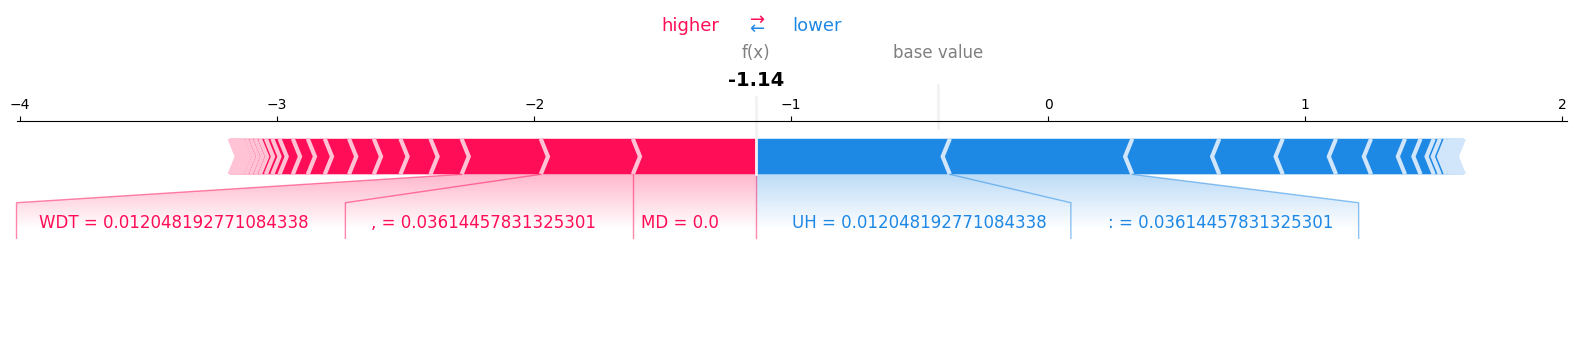

In [22]:
shap.force_plot(
    explainer.expected_value[1],
    test_shap_val[0],
    result.test_data.iloc[0],
    matplotlib=True,
)

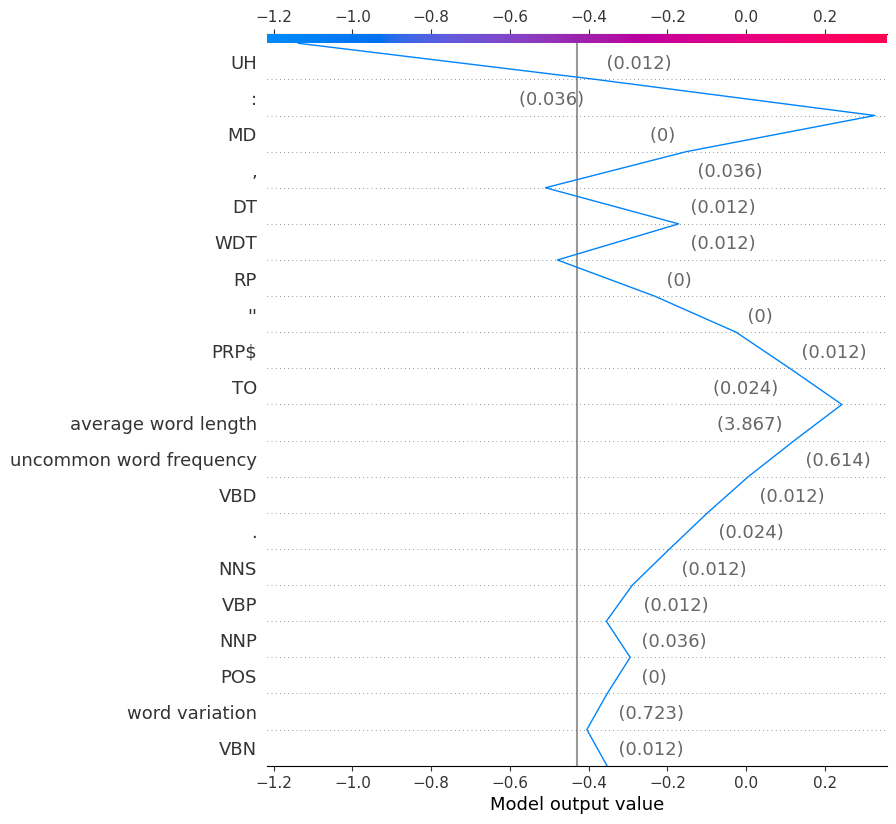

In [19]:
shap.decision_plot(
    explainer.expected_value[1], test_shap_val[0], result.test_data.iloc[0]
)

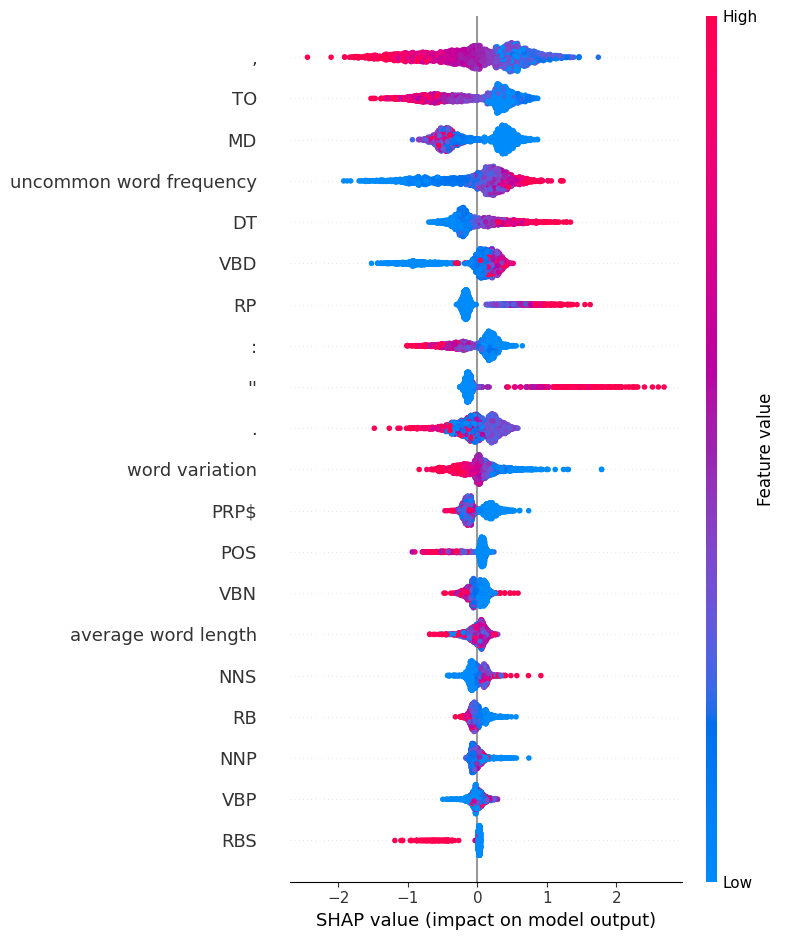

In [20]:
shap.summary_plot(test_shap_val, result.test_data)

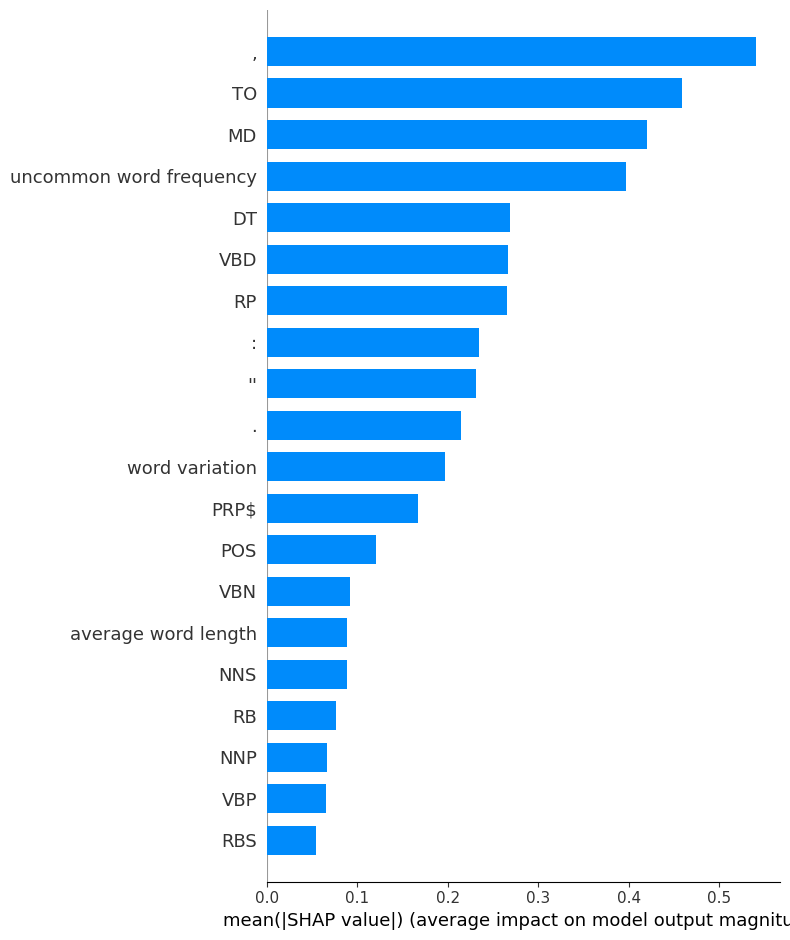

In [21]:
shap.summary_plot(test_shap_val, result.test_data, plot_type="bar")